finish MAD model
<br>
40 dump files used to calculate avg and var as memory allows; only dump[i0] is saved due to memory constraint

In [1]:
from toolz import valmap

import h5py
import pyharm

import matplotlib.pyplot as plt
import numpy as np
from numpy import ma
from matplotlib import ticker, cm
import pyharm.plots.plot_dumps as pplt

from mpl_toolkits import mplot3d

In [2]:
i0 = 5010 # initial  frame
i1 = 5051 # 1 + last frame

fmt = 'torus.out0.{:05d}.h5'

qualities = ['RHO', 'Pg', 'bsq', 'beta', 'Theta', 'Thetae']

In [3]:
# some constants
cl = 29979245800.0 # speed of light in cgs
mp = 1.67262171e-24
kb = 1.3806505e-16
mu = 1.

In [4]:
def fname(i, src): # closure on `src` and `fmt`
    return (src+fmt).format(i)

In [5]:
src_ma_10M = '/xdisk/chanc/share/GRMHD_dt10M/Ma+0.94_w5/'
src_sa_10M = '/xdisk/chanc/share/GRMHD_dt10M/Sa+0.94_w5/'

src_ma_1000M = '/xdisk/chanc/share/GRMHD_dt1000M/Ma+0.94_w5/'
src_sa_1000M = '/xdisk/chanc/share/GRMHD_dt1000M/Sa+0.94_w5/'

dump0 = pyharm.load_dump(fname(i0, src_ma_10M))
R_low = 1.
R_high = [1, 10, 40, 160]
# first row of SANE model params

In [6]:
def get_dumps(i0, i1, src, step=1):
    dumps = {}
    for i in range(i0, i1, step):
        dumps[str(i)] = pyharm.load_dump(fname(i, src))
    return dumps

for later variance($\rho$|$P_{g}$|$P_{mag}$) calculations

In [7]:
def average(irange, dumps, keys):
    s = {k:0 for k in keys}
    for i in irange:
        # print('i:', i)
        # Because data I/O is expensive, we load the data once ...
        d = dumps[str(i)].cache
        # print('d:', d)
        # ... and then sum over multiple keys
        for k in keys:
            s[k] += d[k] # i.e.: s[key1] = file1[key1] + file2[key1] + file3[key1] + ...
            # print('s[k]:', s[k])
            # print('d[k]', d[k])
    print('finish average calculation.')
    return valmap(lambda v: v/len(irange), s) # return an average of variables from the files read in

In [8]:
# works; returns an array of arrays with numerical values
def variance(irange, dumps, quality='Te'):
    """
    quality: str, the physical quality whose variance values we want (e.g. 'Te' for electron temperature)
    dumps: dictionary, all the dump files read in
    """
    key = 'var' + quality
    ss = {key: 0}
    for i in irange:
        d = dumps[str(i)].cache
        ss[key] += (d[quality]-d['avg' + quality])**2
    for i in irange:
        dumps[str(i)].cache[key] = ss[key]
    print('finish variance & standard deviation calculation\'s loop.')
    return valmap(lambda v: v/len(irange), ss)

$\gamma = \frac{4}{3}$, $x_{e} = \frac{1}{4}$, so ions:electrons = 3:1 (y=1, z=3; $\gamma_{i}=\gamma=\frac{4}{3}, \gamma_e = \gamma + x_{e} / (1 - x_{e})(5/3 - \gamma) = \frac{7}{3}$) <br> 
$Const = m_{p}(\gamma_{e}-1)(\gamma_{i}-1)$ <br> 
$const1 = y(\gamma_{i}-1)$ <br>
$const2 = z(\gamma_{e}-1)$ <br>
$const3 = k_{B}(\gamma-1)$

In [9]:
# constants used for the functions
y = 1.
z = 3.
gamma = 4/3
gamma_i = 4/3
gamma_e = 7/3
const = mp*(gamma_e - 1)*(gamma_i - 1)
const1 = y*(gamma_i - 1)
const2 = z*(gamma_e - 1)
const3 = kb*(gamma - 1)

$R=\frac{R_{low}}{P_{mag}^{2}+P_{g}^{2}}+\frac{R_{high}P_{g}^{2}}{P_{mag}^{2}+P_{g}^{2}}$

In [10]:
def R(dump, Rh, Rl, Pmag):
    Pg = dump['Pg']
    return Rl/(Pmag**2+Pg**2)+Rh*Pg**2/(Pmag**2+Pg**2)

The derived correlation functions: https://www.overleaf.com/project/648f4ef47315ccb8acbff565 <br>
For variance($\rho$): $F_{1}(\rho, P_{g}, P_{mag}) = -\frac{Const}{const3}\frac{P_{g}}{\rho^{2}\cdot k_{B}[const1+R\cdot const2]}$ <br>
For variance($P_{g}$): $F_{2}(P_{g}, P_{mag})= \frac{Const}{c3}[\frac{1}{c1+c2\cdot(\frac{P_{mag}^{2}R_{low}}{P_{mag}^{2}+P_{g}^{2}}+\frac{P_{g}^{2}R_{high}}{P_{mag}^{2}+P_{g}^{2}})}-\frac{c2P_{g}(\frac{2R_{high}P_{g}}{P_{mag}^{2}+P_{g}^{2}}-\frac{2R_{high}P_{g}^{3}}{(P_{mag}^{2}+P_{g}^{2})^{2}}-\frac{2R_{low}P_{g}}{(P_{mag}^{2}+P_{g}^2)^{2}})}{(c1+c2\cdot(\frac{P_{mag}^{2}R_{low}}{P_{mag}^{2}+P_{g}^{2}}+\frac{P_{g}^{2}R_{high}}{P_{mag}^{2}+P_{g}^{2}})^{2}}]$ <br>
For variance($P_{mag}$): $F_{3}(P_{g}, P_{mag}) = \frac{c2(R_{high}-R_{low})P_{g}^{2}}{[c1\cdot(P_{mag}^{2}+P_{g}^{2})+c2\cdot(P_{mag}^{2}R_{low}+P_{g}^{2}R_{high})]^{2}}$ 

In [11]:
# rho
def F1(dump, Rh, Rl):
    rho = dump['RHO']
    Pg = dump['Pg']
    B2 = dump['bsq']
    Pmag = B2/(2*mu)
    r = R(dump, Rh, Rl, Pmag)
    
    frac = Pg/(rho**2*kb*(const1+r*const2))
    val = -const/const3*frac
    # dump.cache['D1'] = val
    dump.cache['coeff1'] = val**2

In [12]:
# Pg
def F2(dump, Rh, Rl):
    rho = dump['RHO']
    Pg = dump['Pg']
    B2 = dump['bsq']
    Pmag = B2/(2*mu)
    r = R(dump, Rh, Rl, Pmag)
    
    frac1 = 1/(const1*(Pmag**2+Pg**2)+const2*(Pmag**2*Rl/(Pmag**2+Pg**2)+Pg**2*Rh/(Pmag**2+Pg**2)))
    numerator2 = const2*Pg*(2*Rh*Pg/(Pmag**2+Pg**2)-2*Rh*Pg**3/(Pmag**2+Pg**2)**2-2*Rl*Pg/(Pmag**2+Pg**2)**2)
    denom2 = const1+const2*(Pmag**2*Rl/(Pmag**2+Pg**2)+Pg**2*Rh/(Pmag**2+Pg**2))
    # dump.cache['F2'] = const/const3*(frac1-numerator2/denom2)
    val = const/const3*(frac1-numerator2/denom2)
    # dump.cache['D2'] = val
    dump.cache['coeff2'] = val**2

In [13]:
# P_mag (coeff3 adjusted to dump.cache['bsq'])
def F3(dump, Rh, Rl):
    rho = dump['RHO']
    Pg = dump['Pg']
    B2 = dump['bsq']
    Pmag = B2/(2*mu)
    r = R(dump, Rh, Rl, Pmag)
    
    nume = 8*const*const2*const3*(Rh-Rl)*Pg**2
    denom = (const1+const2*r)**2*(4*Pmag**2+Pg**2)**2
    # dump.cache['D3'] = nume/denom
    dump.cache['coeff3'] = 0.25*(nume/denom)**2

In [14]:
src_save_ma = '/home/u12/limengjiang/GRMHD/variances/MAD'
src_save_sa = '/home/u12/limengjiang/GRMHD/variances/SANE'

In [15]:
def save_var(dumps, src_save, Rh, quantity, loop=True):
    '''
    Rh = 1 or 160
    quantity: 'varRHO', 'varPg', 'varbsq', 'varTe', or 'coeff1', 'coeff2', 'coeff3'
    '''
    if loop:
        for key, dump in dumps.items():
            if Rh == 1.:
                name = fname(int(key), src_save+'/Rh1/')
            if Rh == 160.:
                name = fname(int(key), src_save+'/Rh160/')
            hf = h5py.File(name, 'r+')
            ds = dump.cache[quantity]
            hf.create_dataset(quantity, data=ds)
            hf.close()
    else:
        if Rh == 1.:
            name = fname(i0, src_save+'/Rh1/')
        if Rh == 160.:
            name = fname(i0, src_save+'/Rh160/')
        hf = h5py.File(name, 'r+')
        ds = dumps[str(i0)].cache[quantity]
        hf.create_dataset(quantity, data=ds)
        hf.close()

Read in files:

In [16]:
# MAD
dumps_ma = get_dumps(i0, i1, src_ma_10M)

In [18]:
# SANE
dumps_sa = get_dumps(i0, i1, src_sa_10M)

### MAD

In [19]:
for dump in dumps_ma.values():
    dump['RHO']

### $R_{high}$ = $R_{low}$ = 1

the contour tutorial: https://matplotlib.org/stable/gallery/images_contours_and_fields/contourf_log.html <br>
https://www.tutorialspoint.com/matplotlib/matplotlib_3d_contour_plot.htm <br>
https://matplotlib.org/stable/gallery/mplot3d/contour3d_3.html

$F_{1}$

In [17]:
for dump in dumps_ma.values():
    F1(dump, R_high[0], R_low)

In [18]:
rho_ma_coeff_avg = average(range(i0, i1), dumps_ma, ['coeff1'])

finish average calculation.


In [19]:
for dump in dumps_ma.values():
    dump.cache['avgcoeff1'] = np.squeeze(np.array(list(rho_ma_coeff_avg.values())))

In [20]:
save_var(dumps_ma, src_save_ma, Rh=1, quantity='avgcoeff1', loop=False)

In [18]:
rho_ma_f1_avg = average(range(i0, i1), dumps_ma, ['D1'])

finish average calculation.


In [20]:
for dump in dumps_ma.values():
    dump.cache['avgD1'] = np.squeeze(np.array(list(rho_ma_f1_avg.values())))

$F_{2}$

In [17]:
for dump in dumps_ma.values():
    F2(dump, R_high[0], R_low)

In [18]:
Pg_ma_coeff_avg = average(range(i0, i1), dumps_ma, ['coeff2'])

finish average calculation.


In [19]:
for dump in dumps_ma.values():
    dump.cache['avgcoeff2'] = np.squeeze(np.array(list(Pg_ma_coeff_avg.values())))

In [20]:
save_var(dumps_ma, src_save_ma, Rh=1, quantity='avgcoeff2', loop=False)

In [19]:
Pg_ma_f1_avg = average(range(i0, i1), dumps_ma, ['D2'])

finish average calculation.


In [20]:
for dump in dumps_ma.values():
    dump.cache['avgD2'] = np.squeeze(np.array(list(Pg_ma_f1_avg.values())))

$F_{3}$

$R_{high} = R_{low}$, so $F_{3}$ = 0

In [16]:
for dump in dumps_ma.values():
    F3(dump, R_high[0], R_low)

In [17]:
print(dumps_ma[str(i0)].cache['coeff3'][0])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### $R_{high}$=160, $R_{low}$=1

$F_{1}$

In [17]:
for dump in dumps_ma.values():
    F1(dump, R_high[3], R_low)

In [18]:
rho_ma_coeff_avg = average(range(i0, i1), dumps_ma, ['coeff1'])

finish average calculation.


In [19]:
for dump in dumps_ma.values():
    dump.cache['avgcoeff1'] = np.squeeze(np.array(list(rho_ma_coeff_avg.values())))

In [20]:
save_var(dumps_ma, src_save_ma, Rh=160, quantity='avgcoeff1', loop=False)

In [18]:
rho_ma_f1_avg = average(range(i0, i1), dumps_ma, ['D1'])

finish average calculation.


In [19]:
for dump in dumps_ma.values():
    dump.cache['avgD1'] = np.squeeze(np.array(list(rho_ma_f1_avg.values())))

/tmp/ipykernel_37237/2856365850.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax=plt.subplots(1,1)


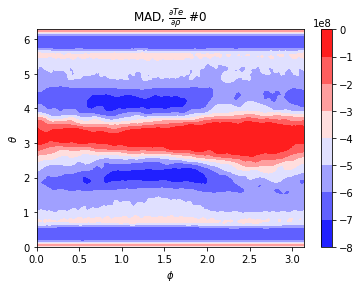

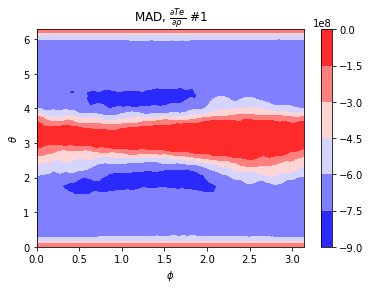

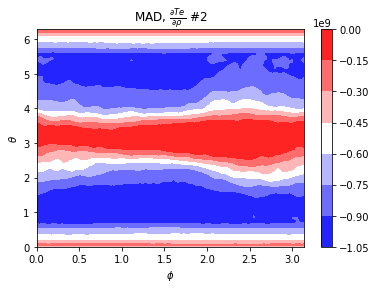

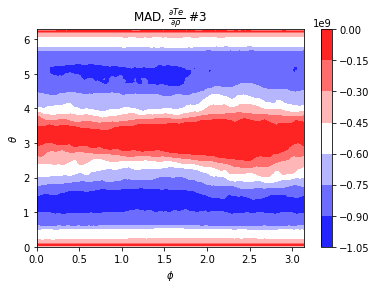

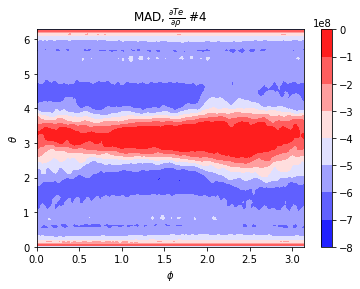

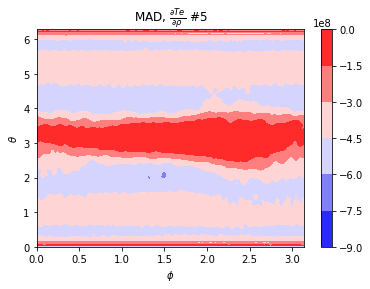

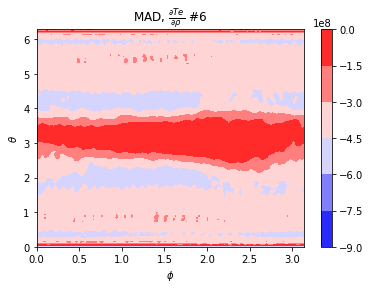

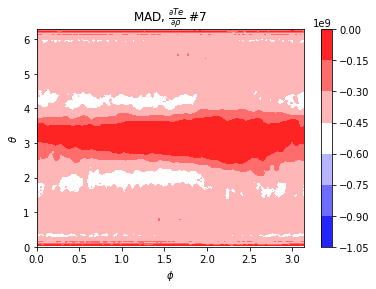

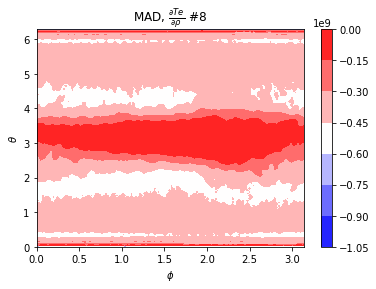

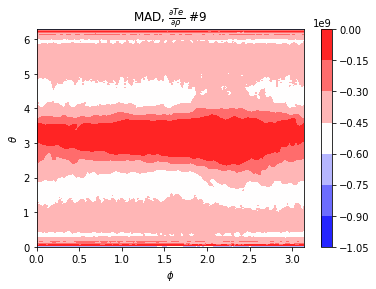

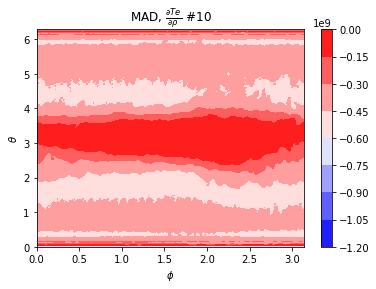

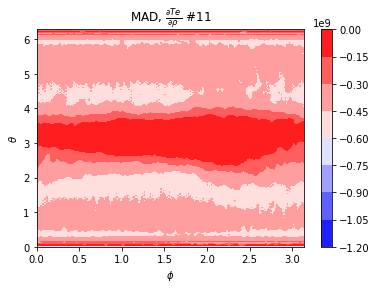

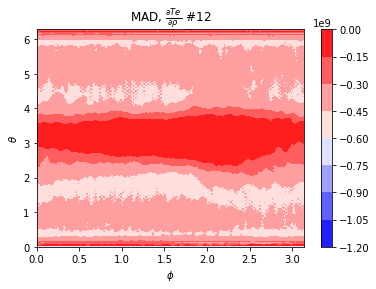

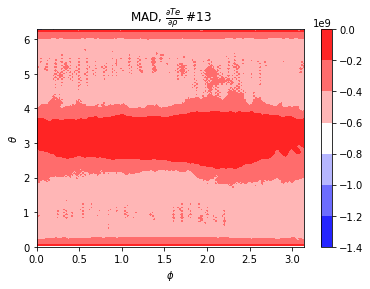

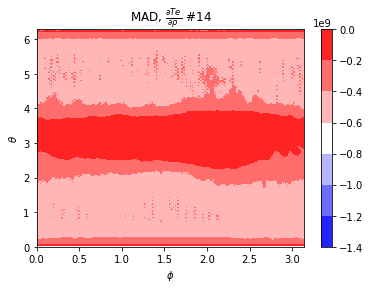

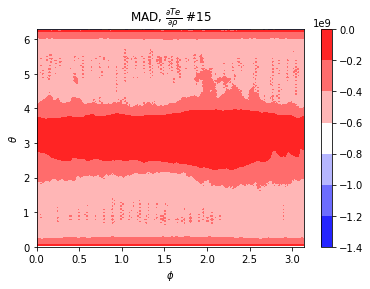

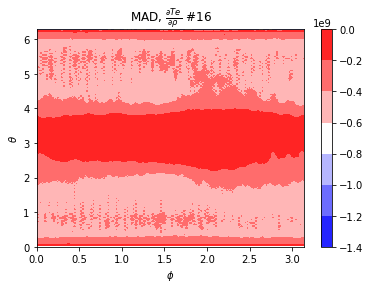

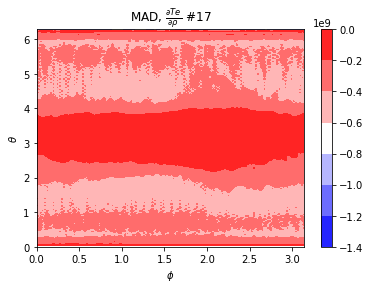

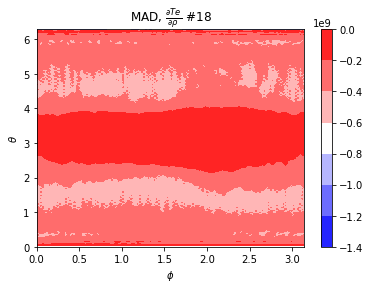

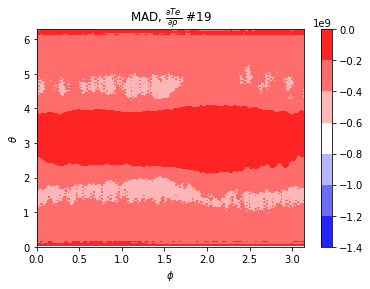

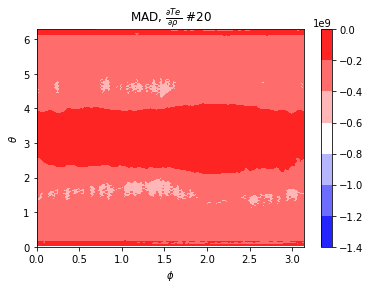

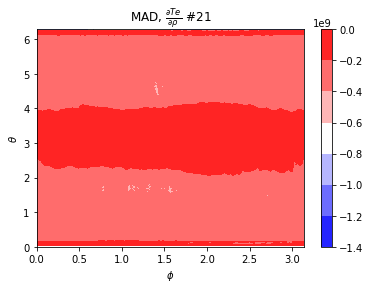

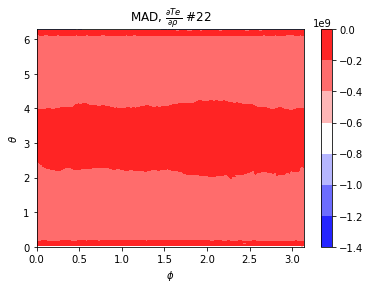

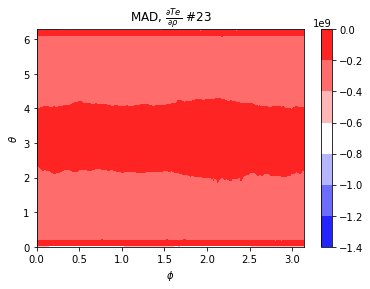

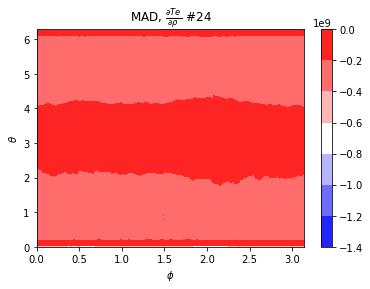

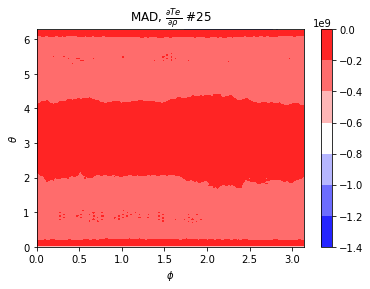

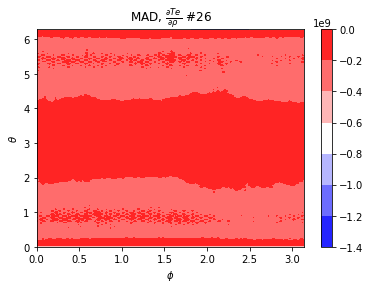

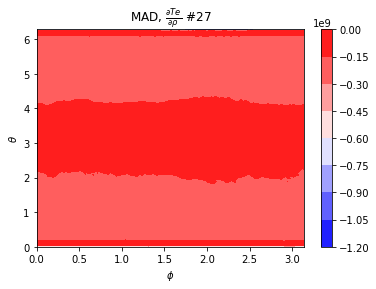

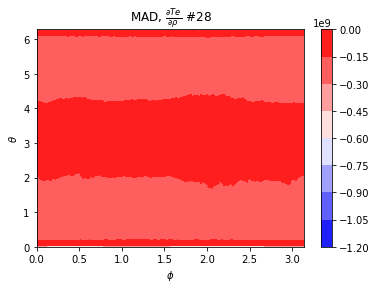

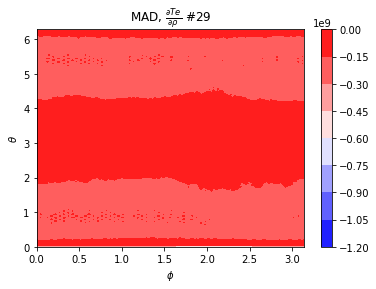

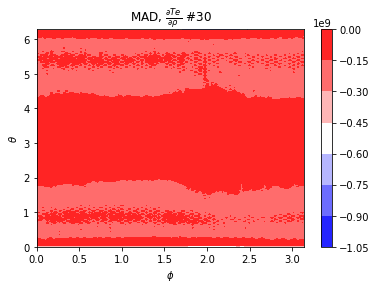

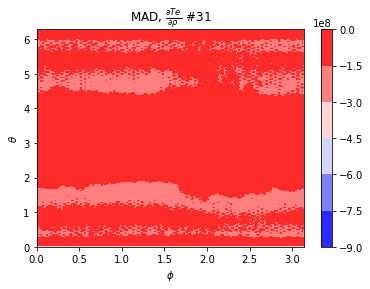

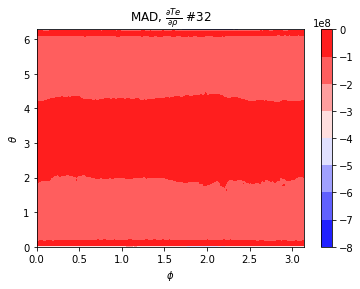

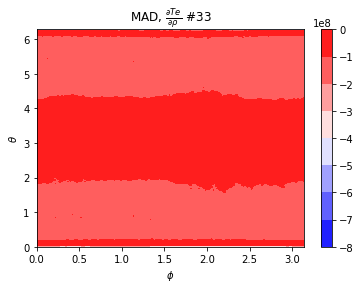

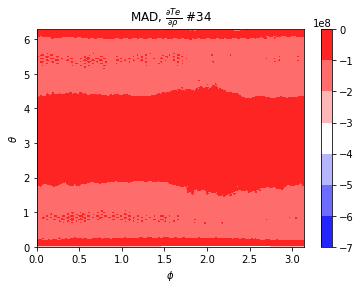

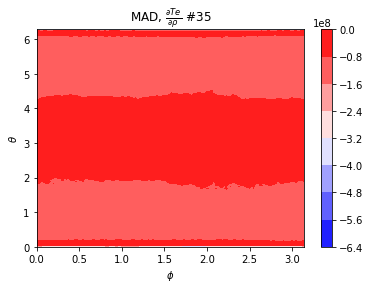

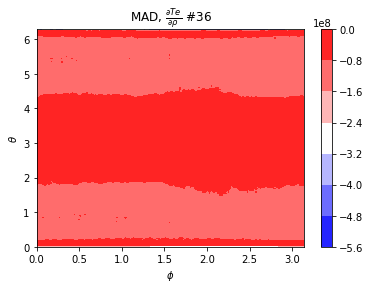

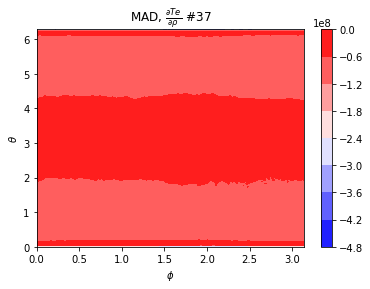

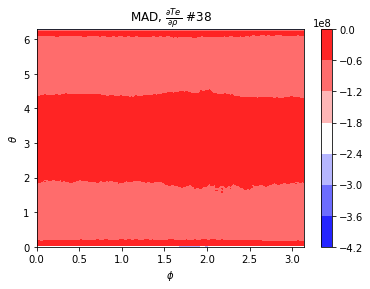

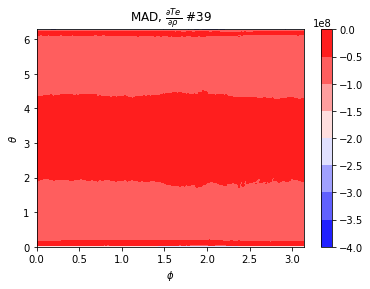

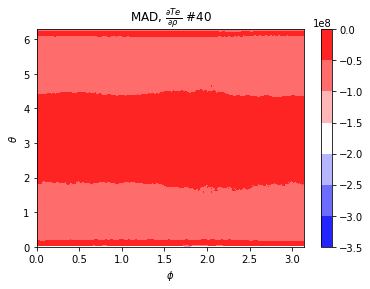

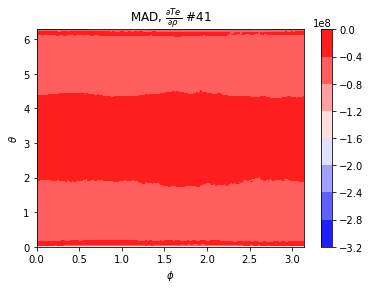

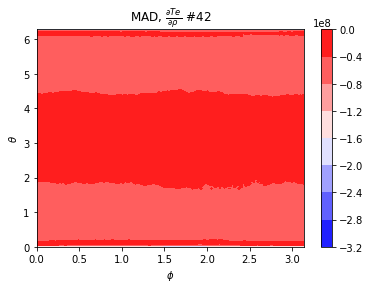

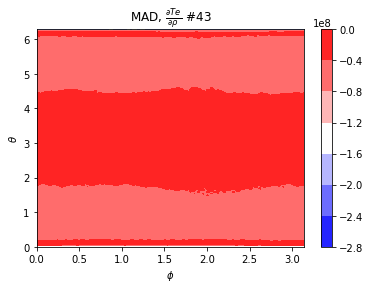

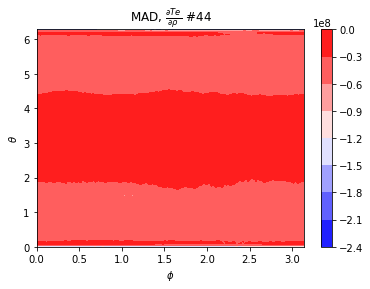

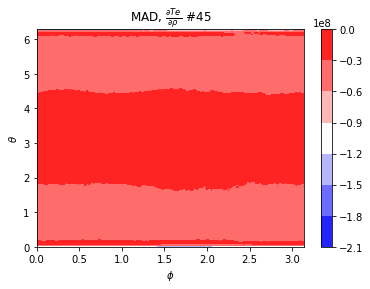

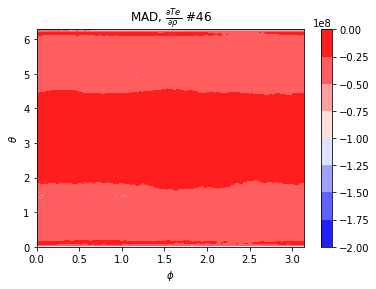

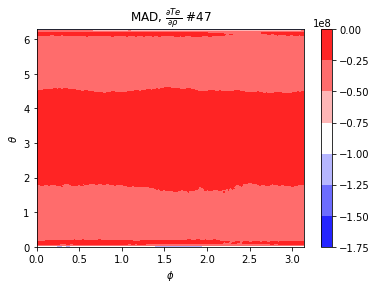

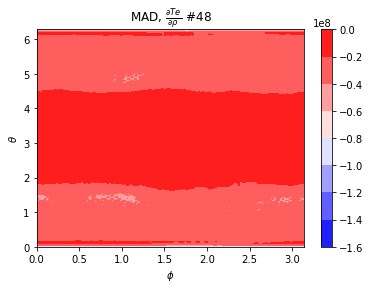

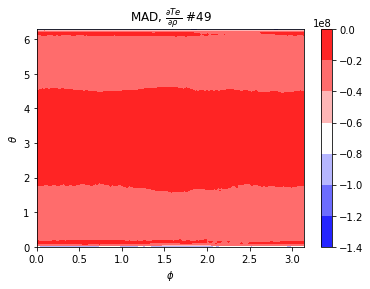

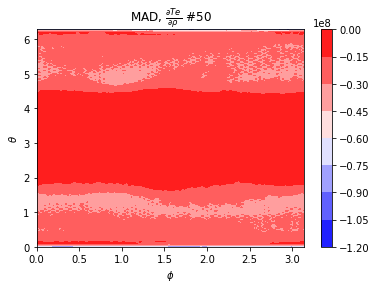

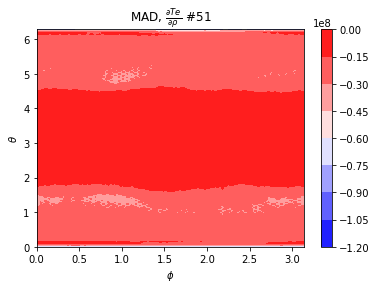

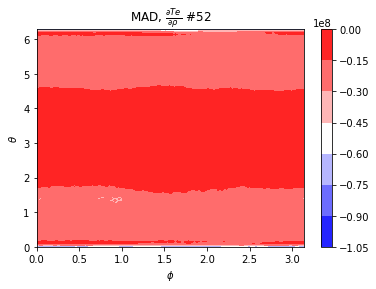

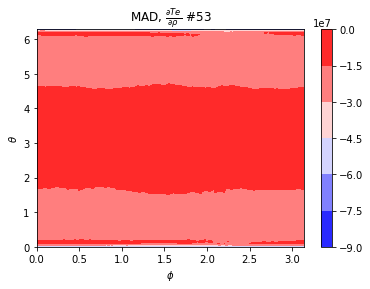

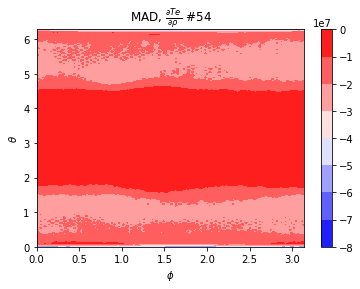

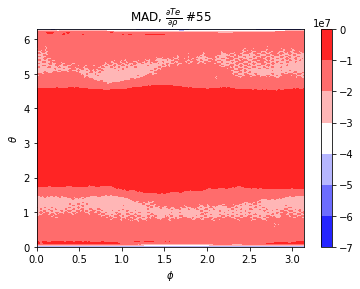

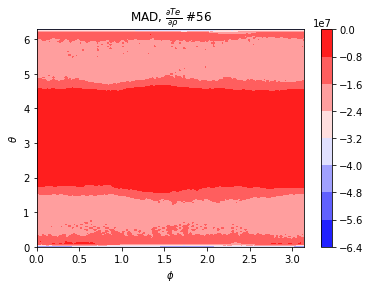

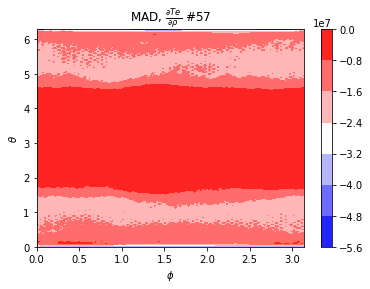

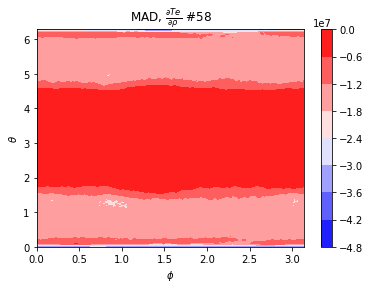

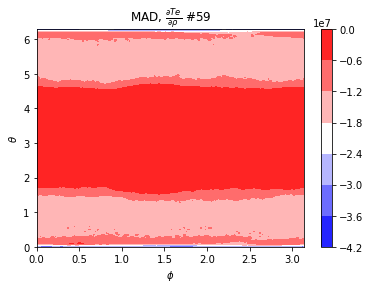

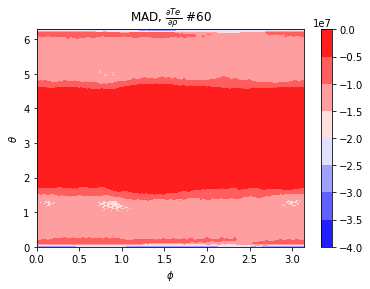

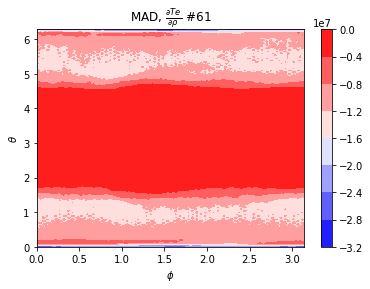

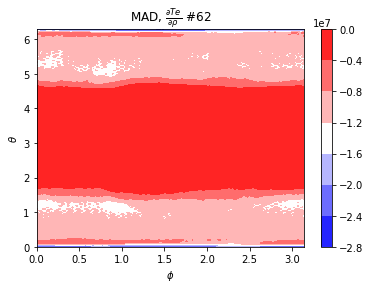

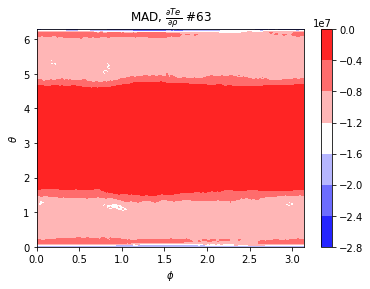

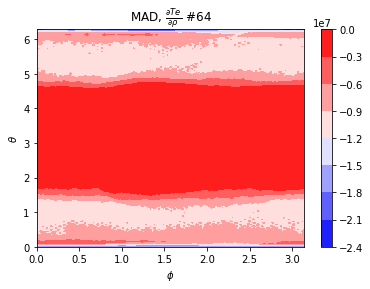

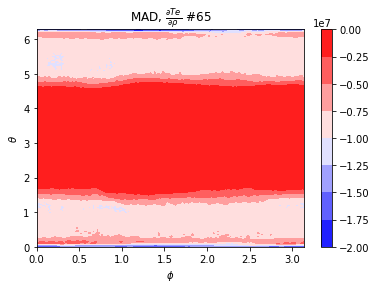

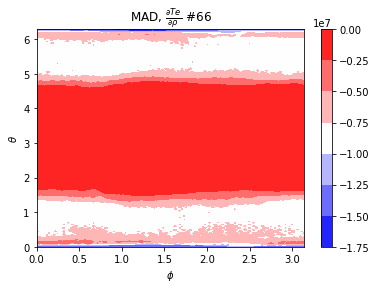

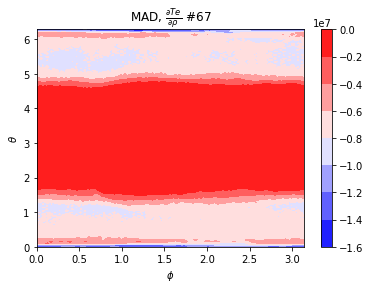

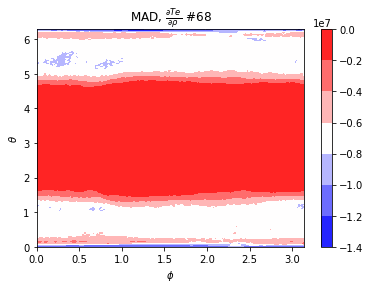

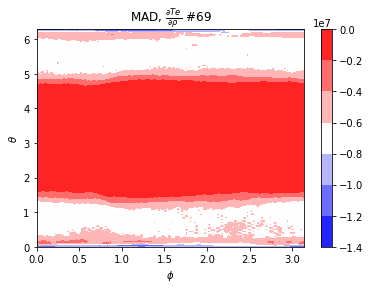

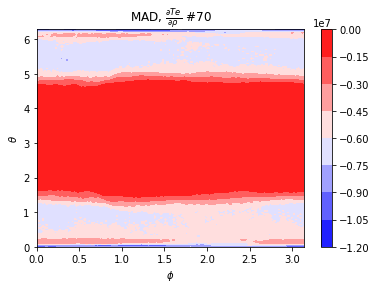

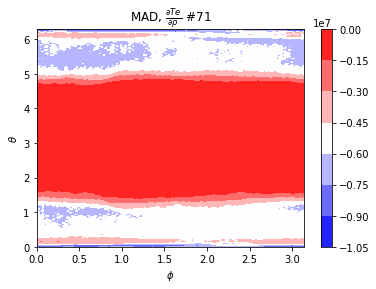

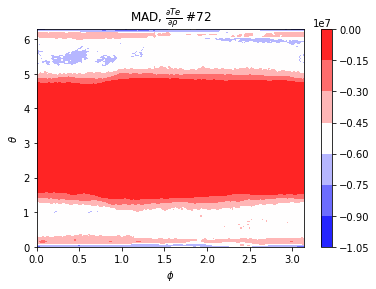

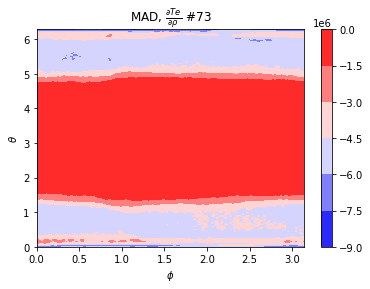

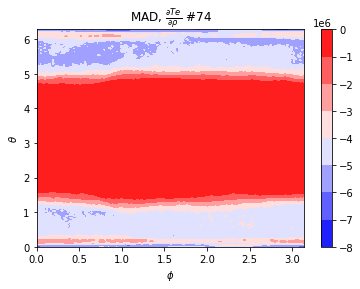

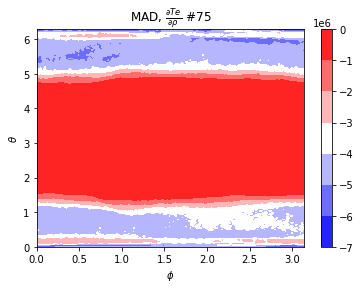

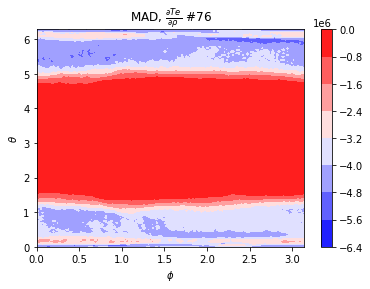

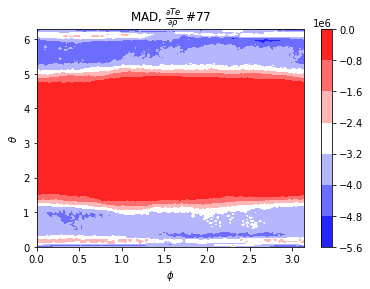

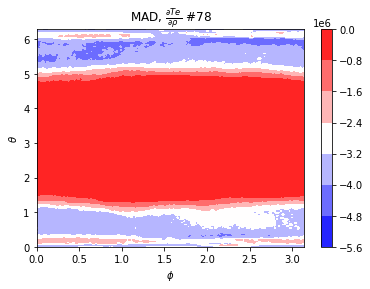

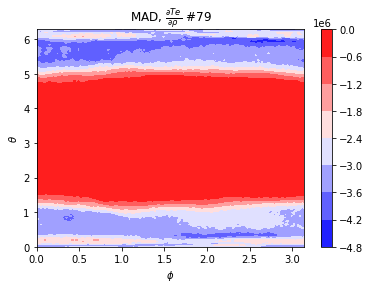

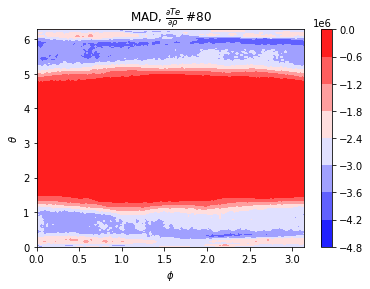

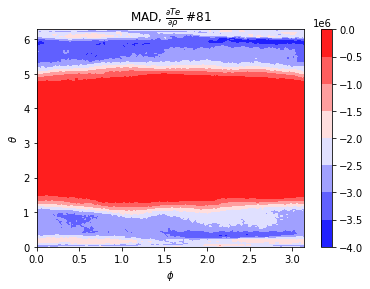

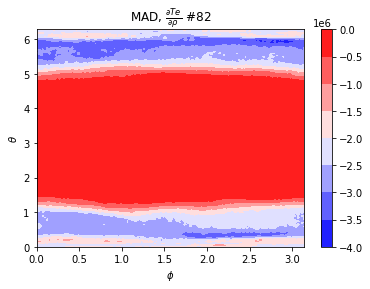

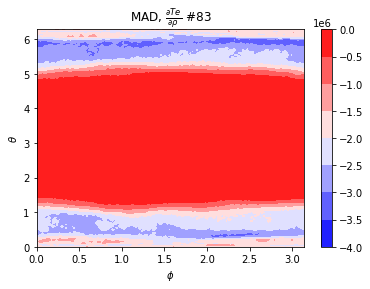

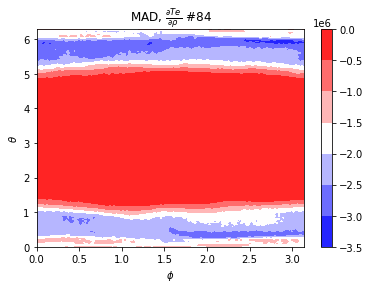

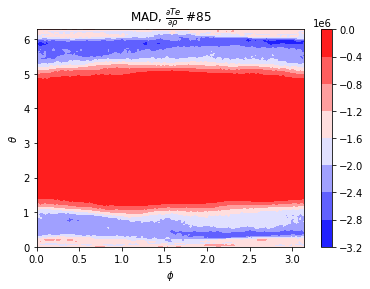

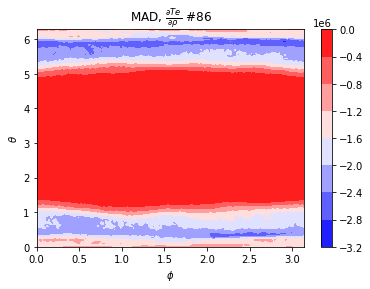

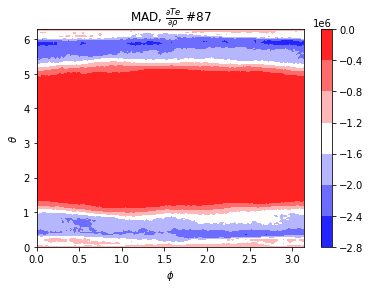

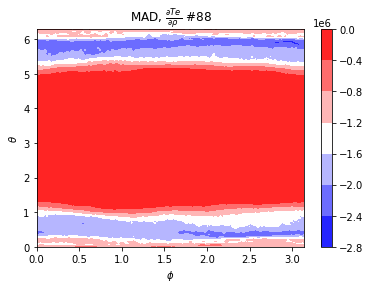

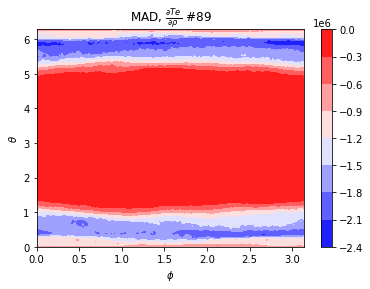

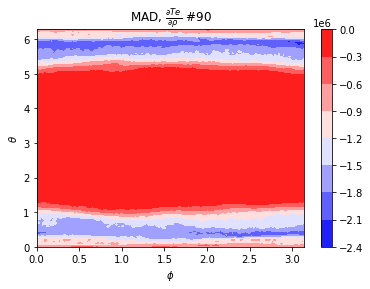

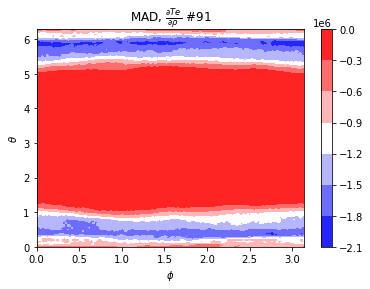

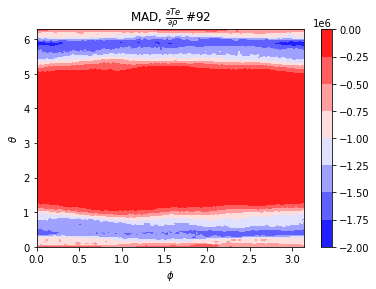

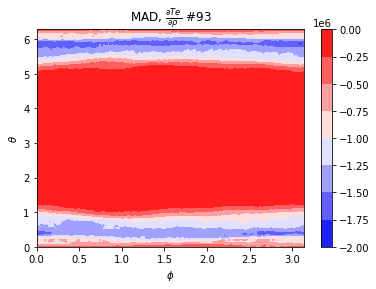

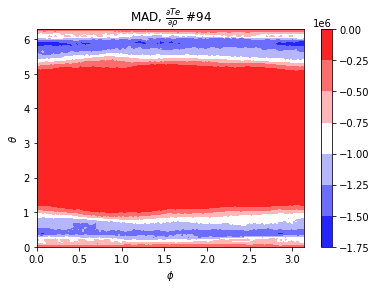

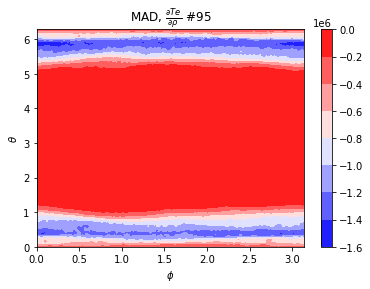

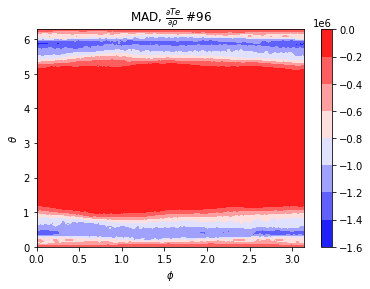

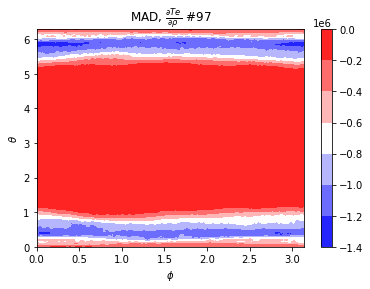

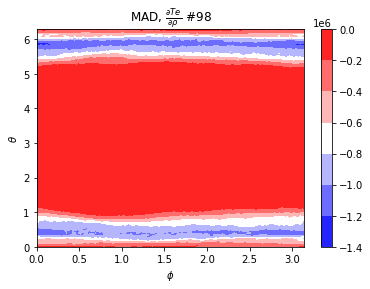

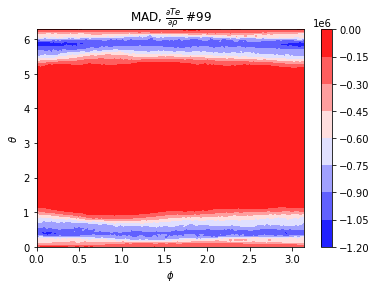

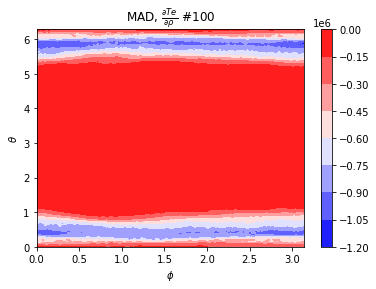

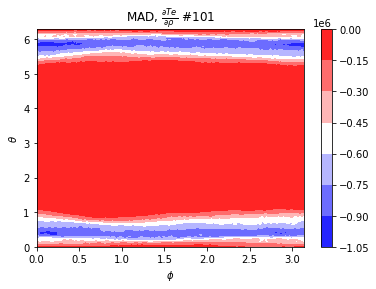

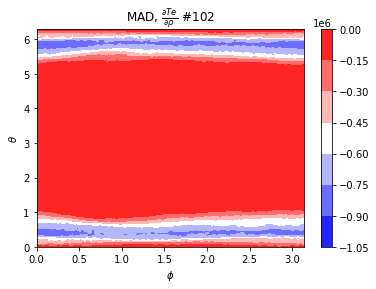

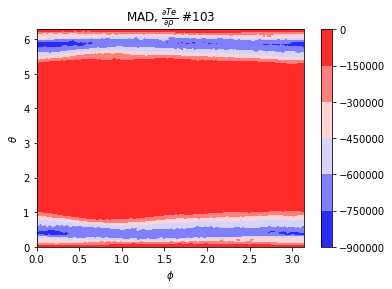

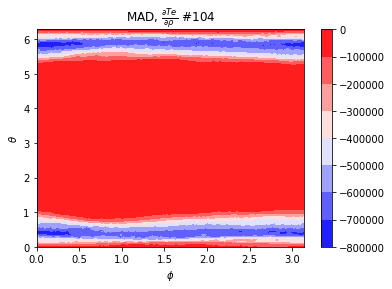

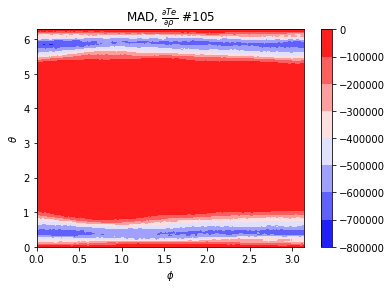

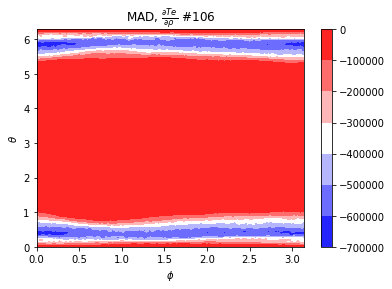

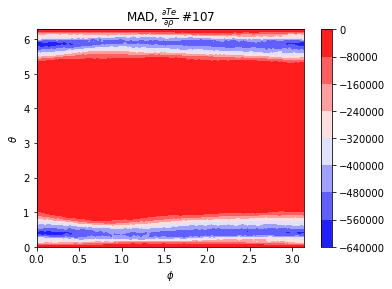

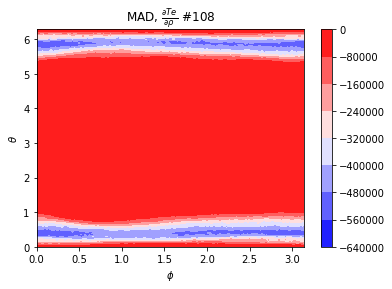

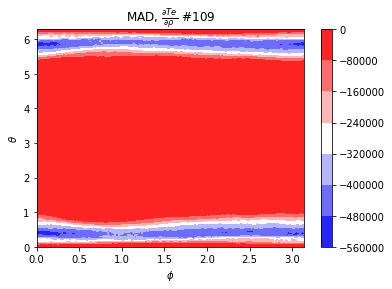

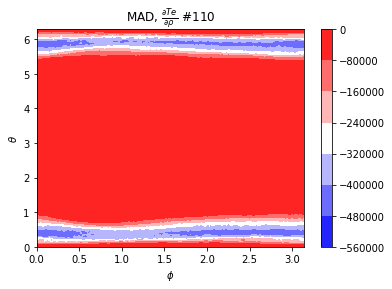

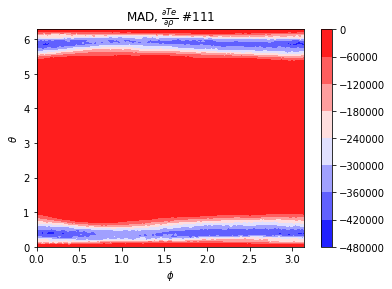

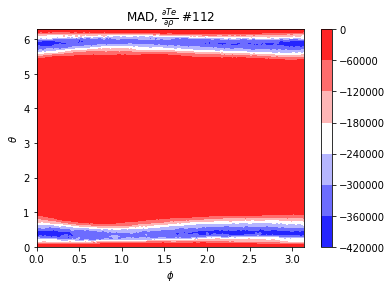

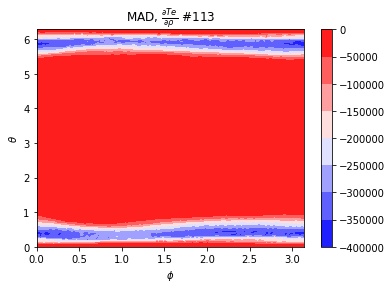

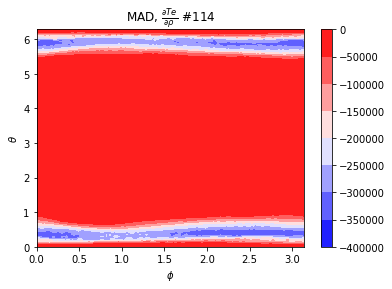

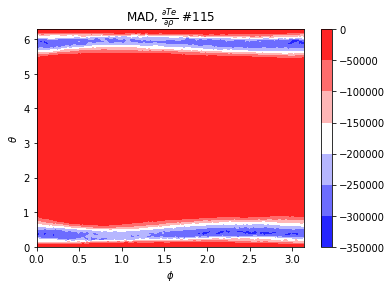

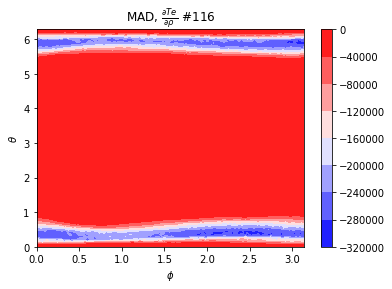

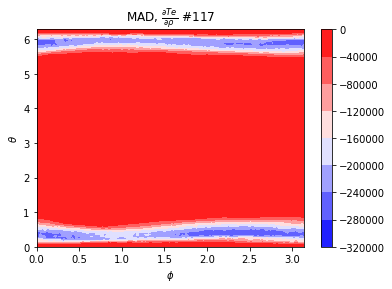

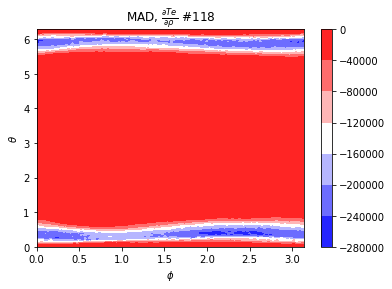

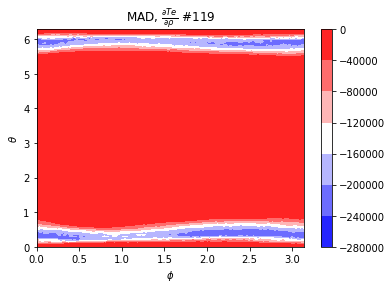

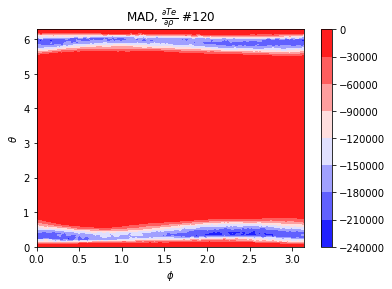

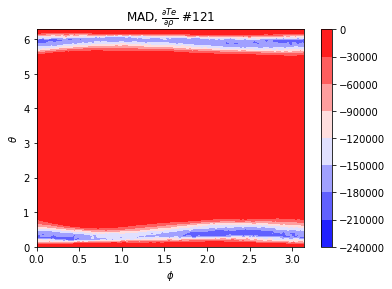

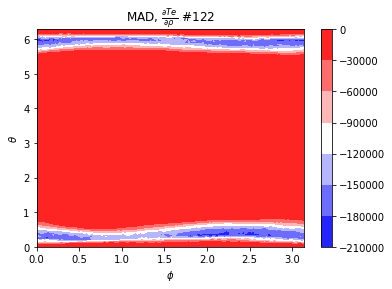

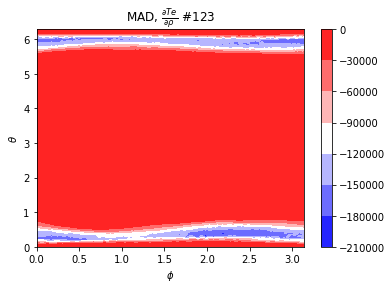

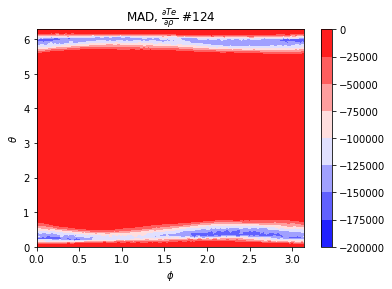

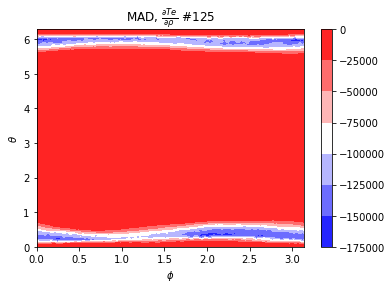

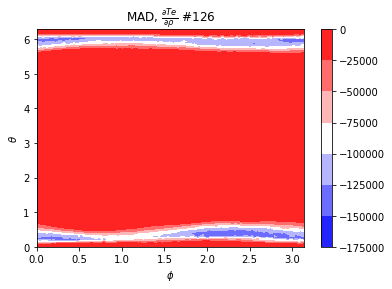

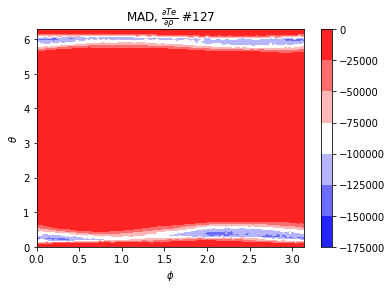

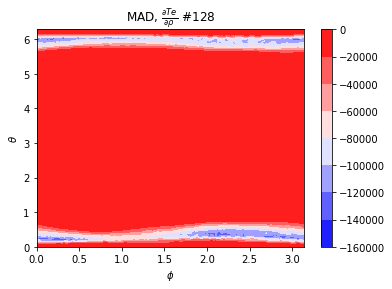

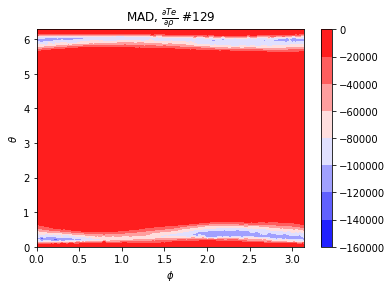

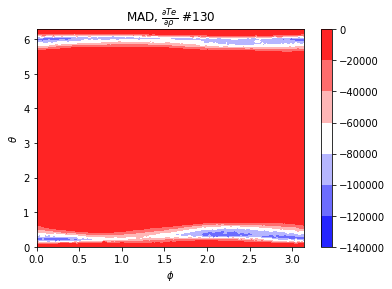

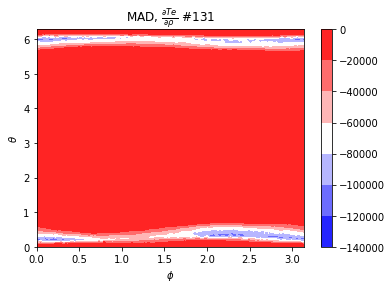

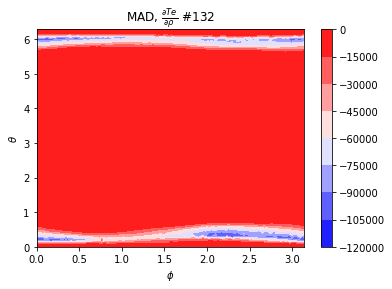

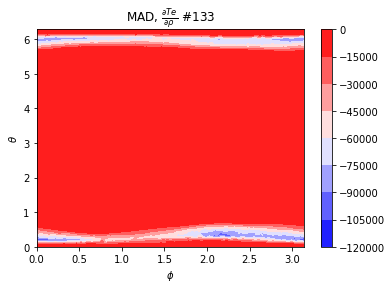

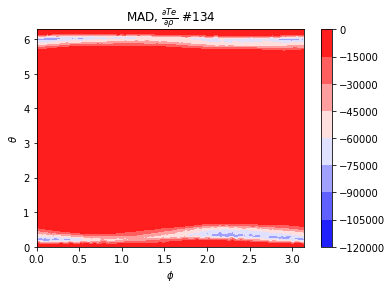

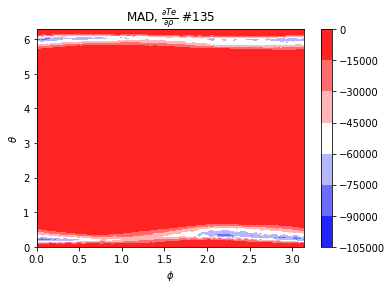

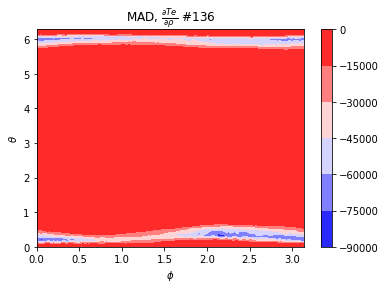

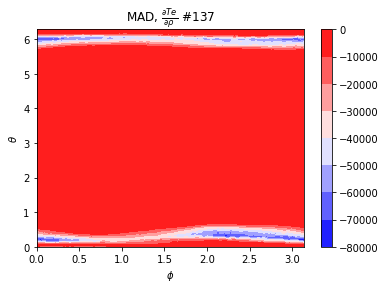

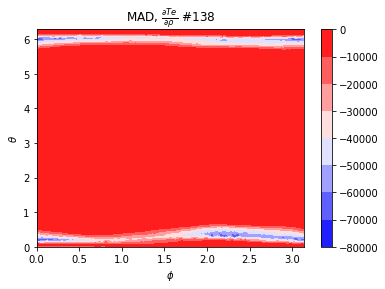

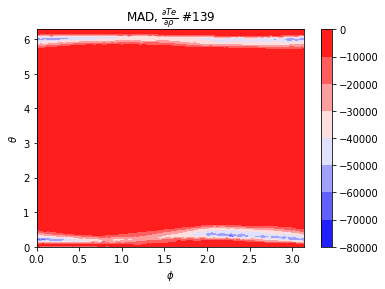

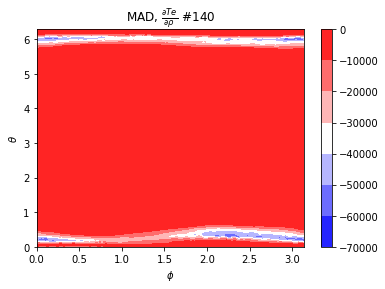

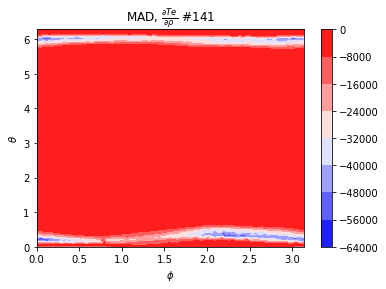

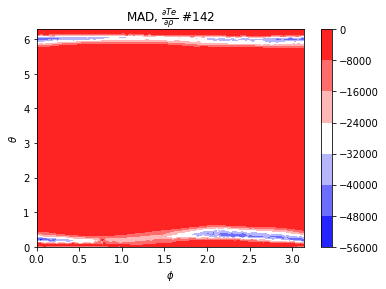

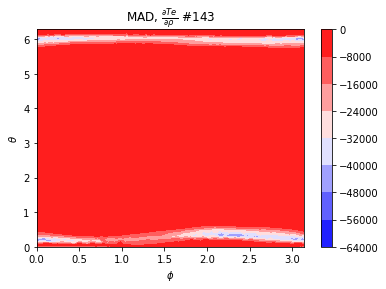

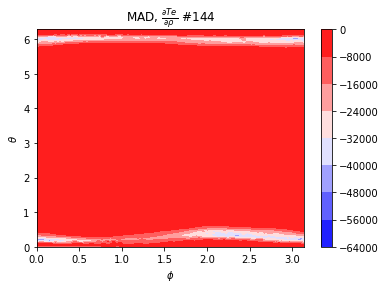

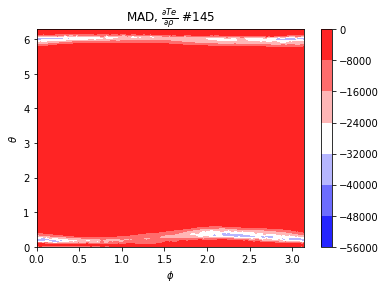

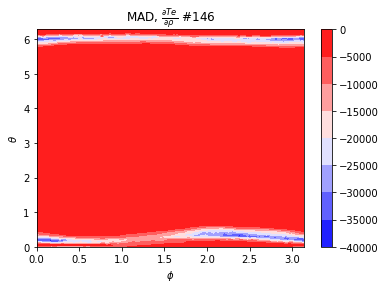

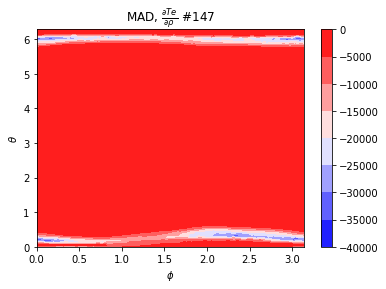

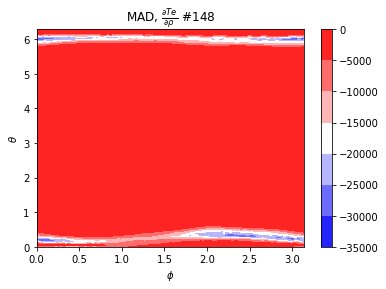

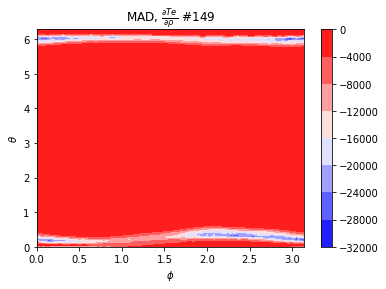

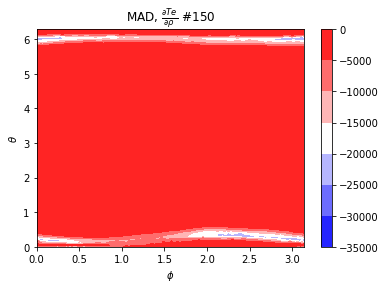

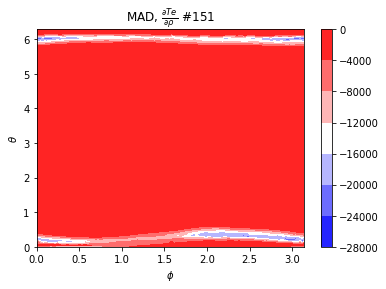

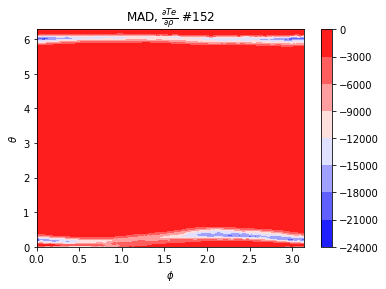

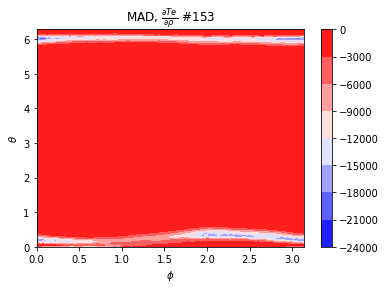

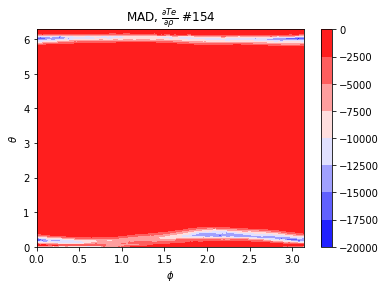

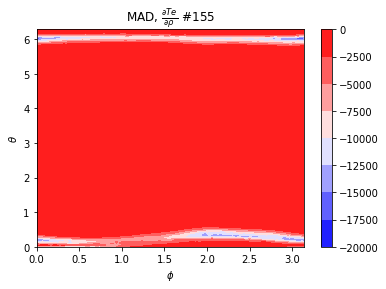

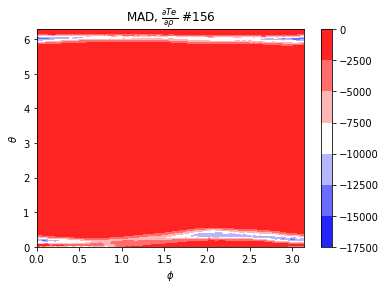

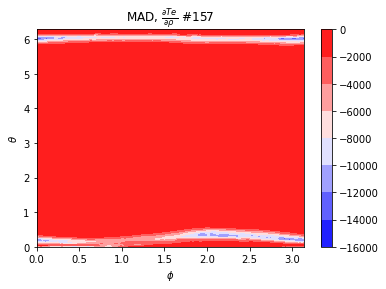

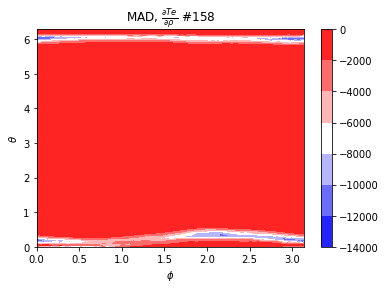

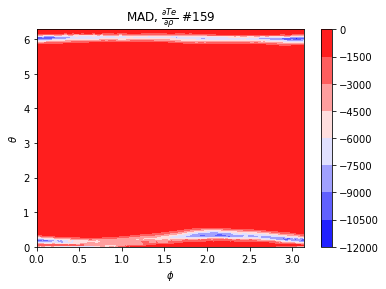

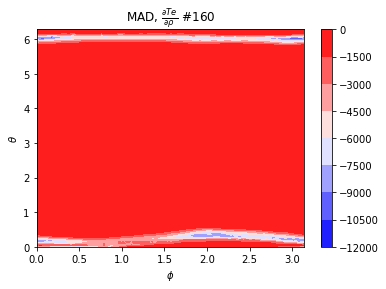

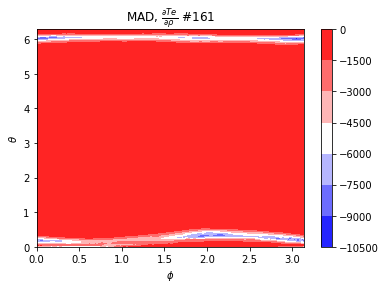

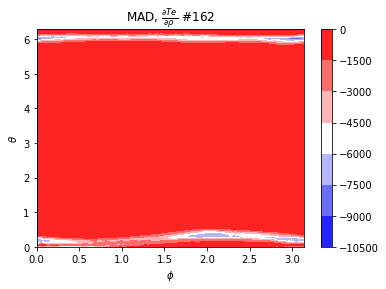

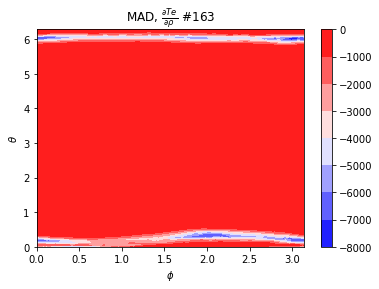

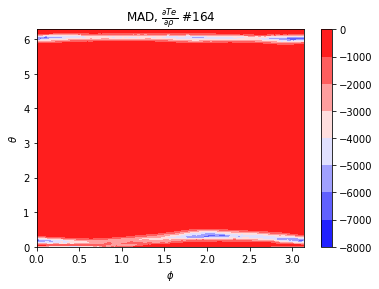

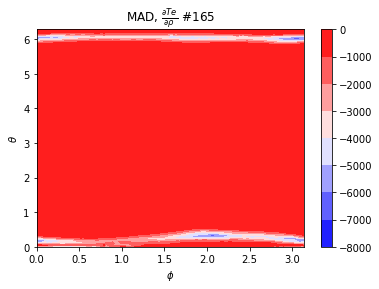

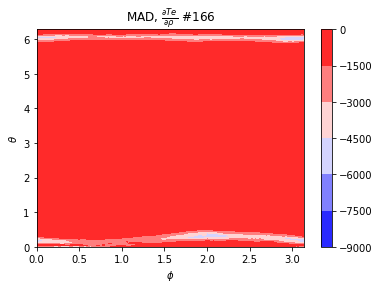

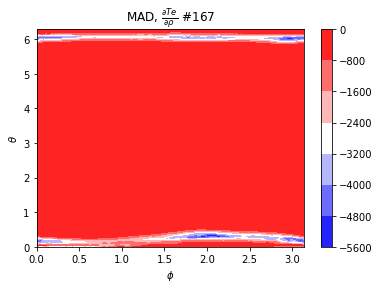

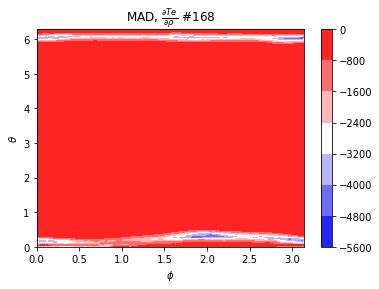

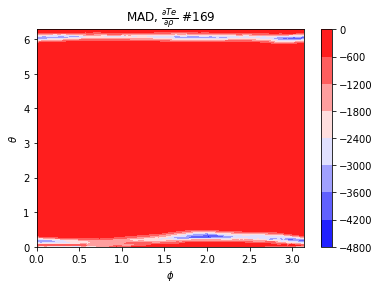

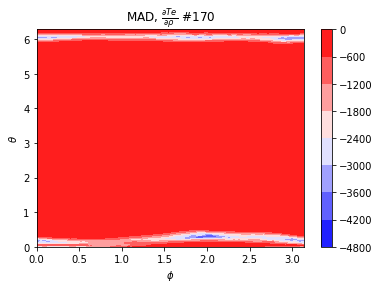

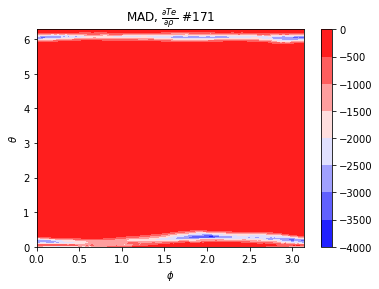

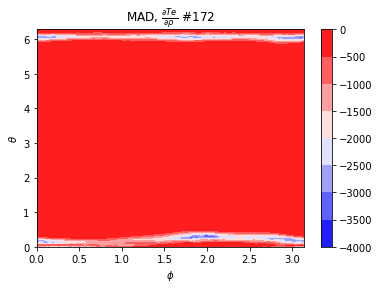

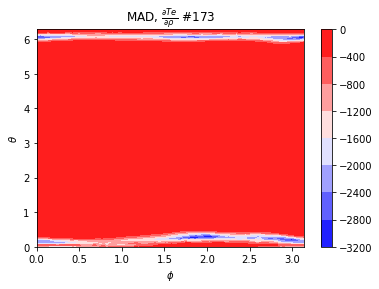

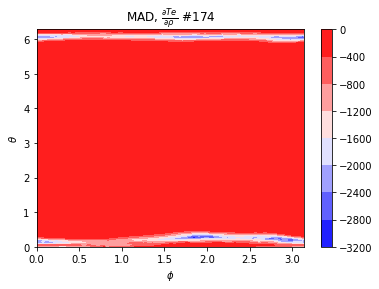

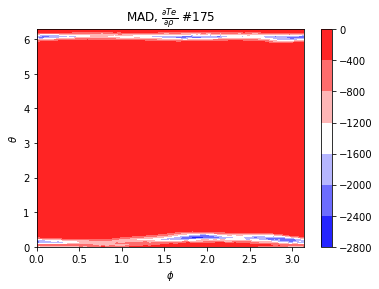

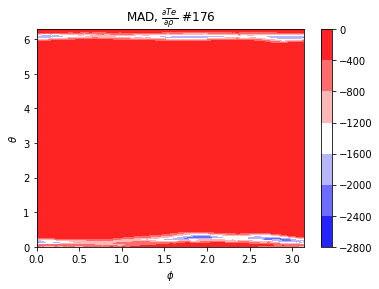

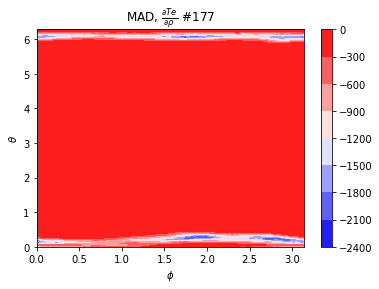

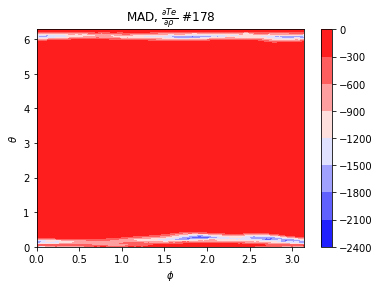

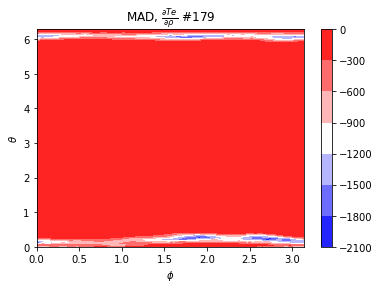

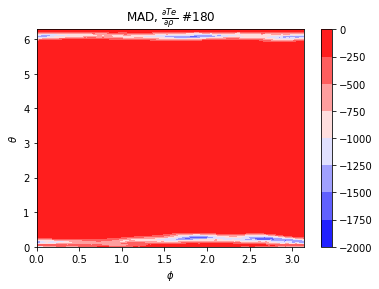

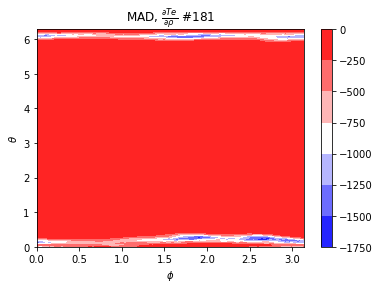

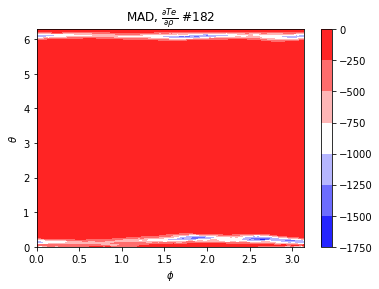

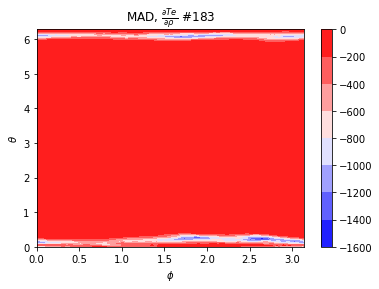

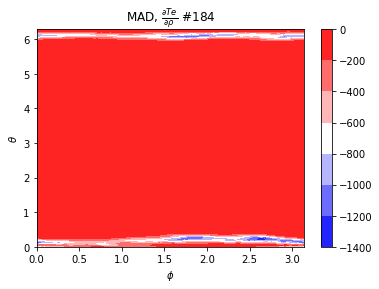

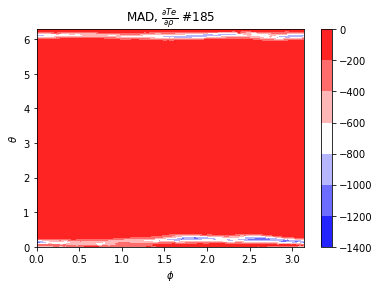

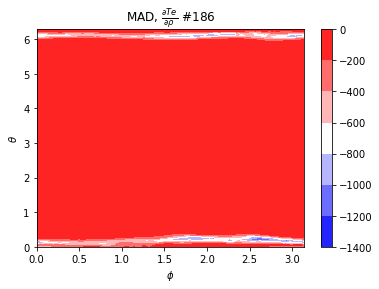

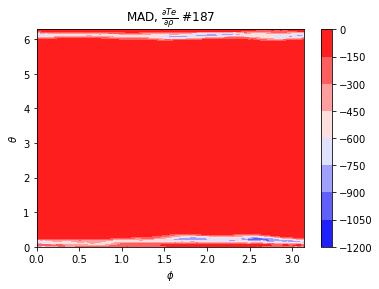

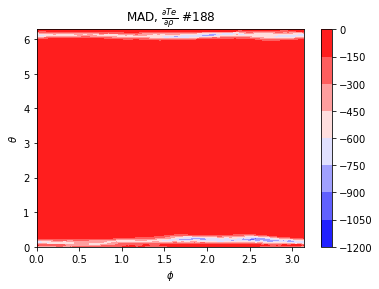

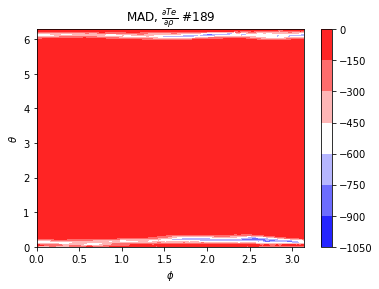

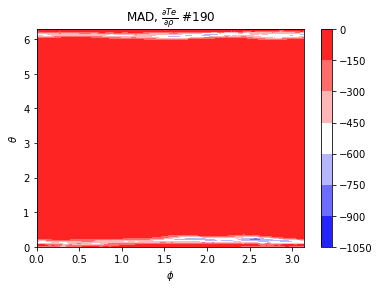

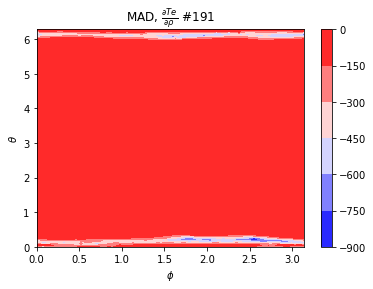

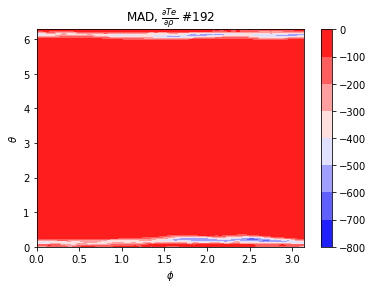

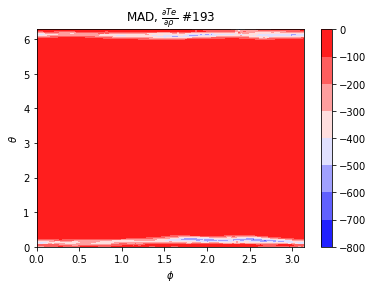

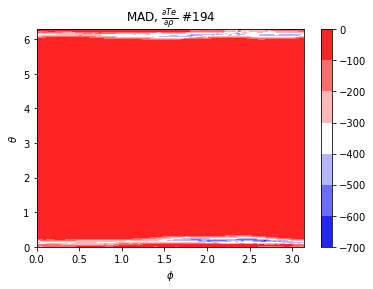

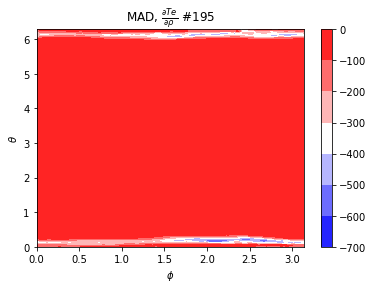

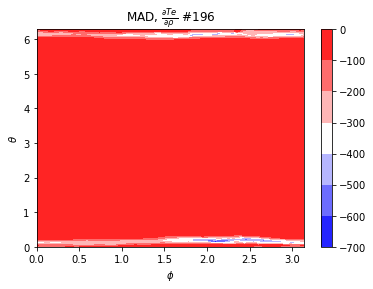

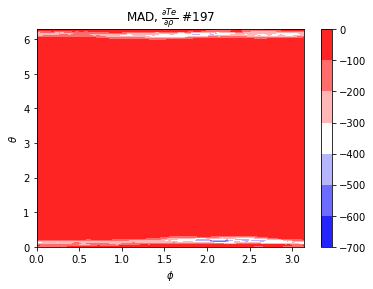

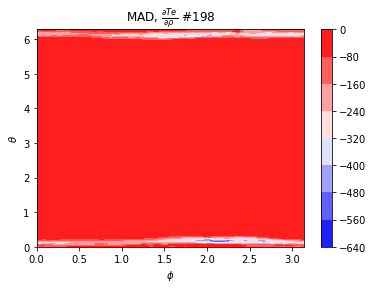

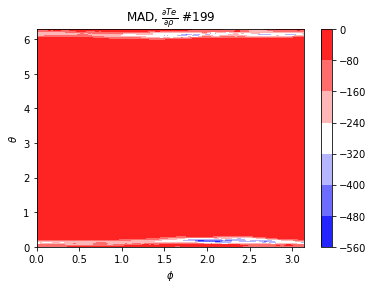

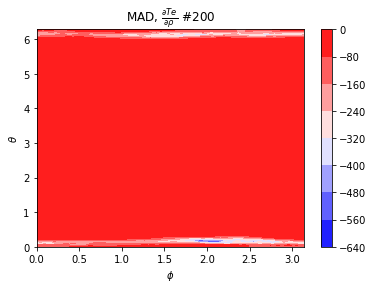

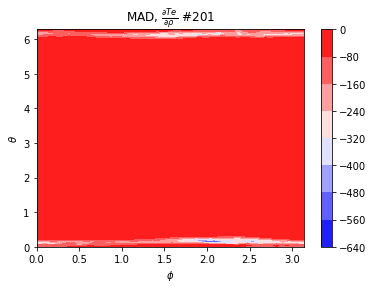

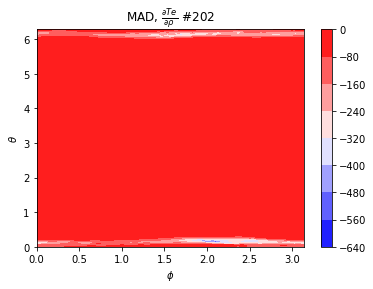

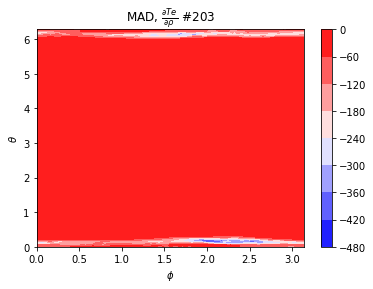

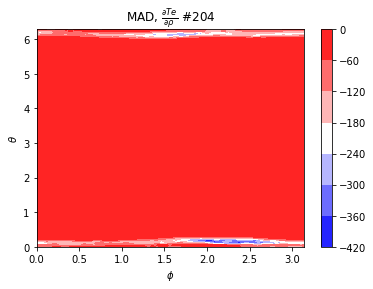

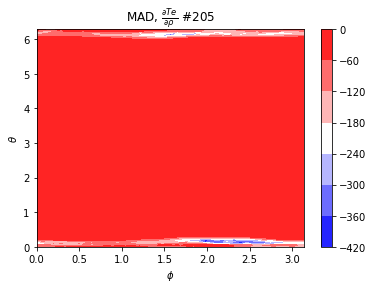

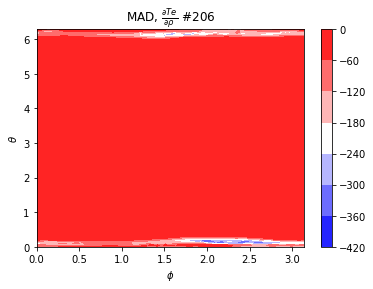

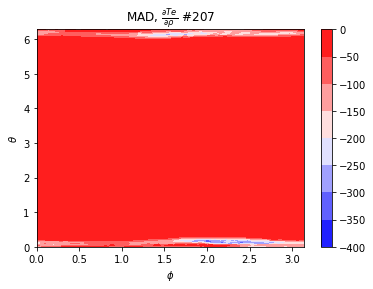

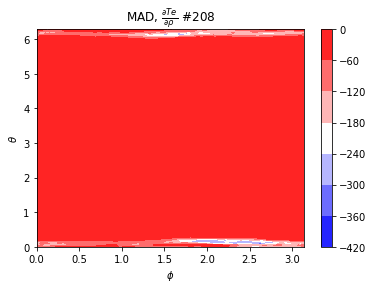

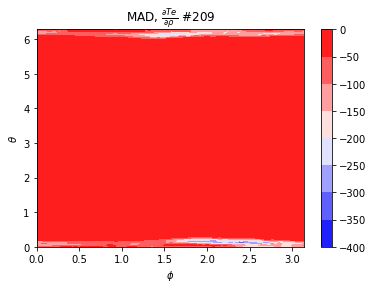

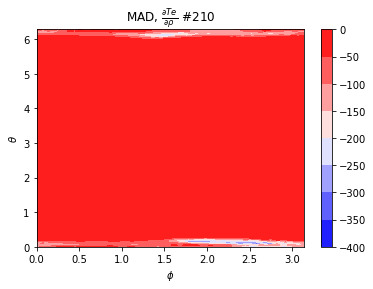

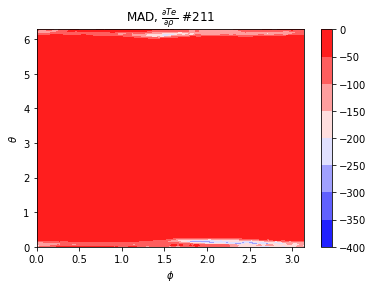

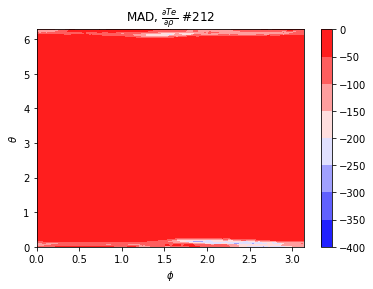

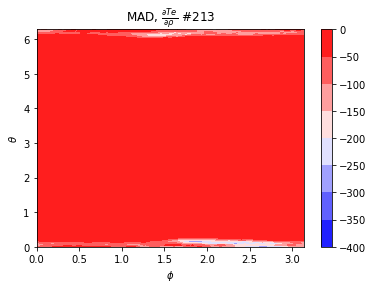

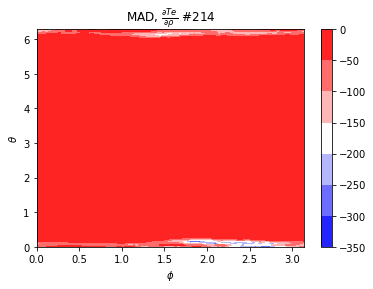

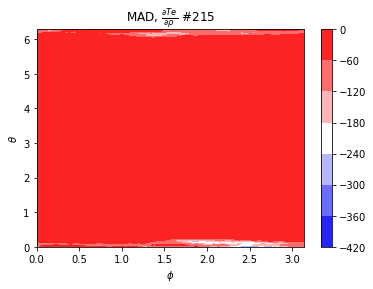

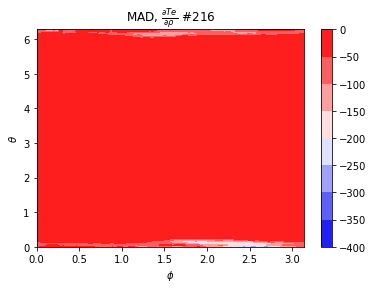

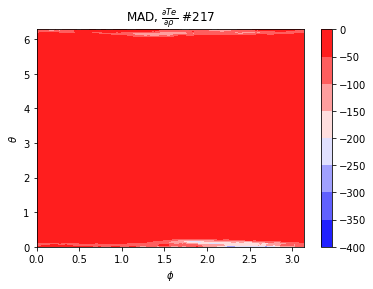

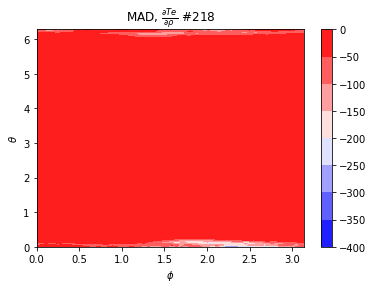

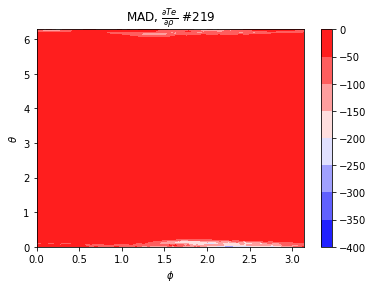

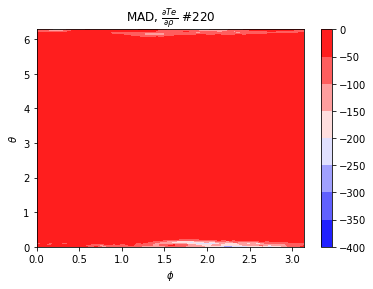

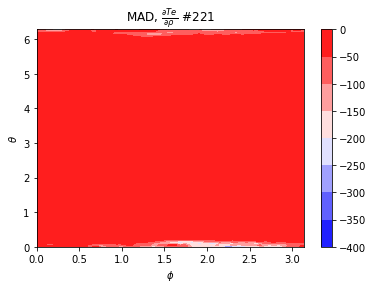

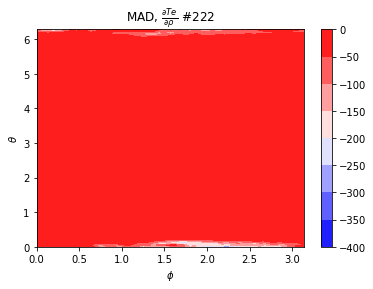

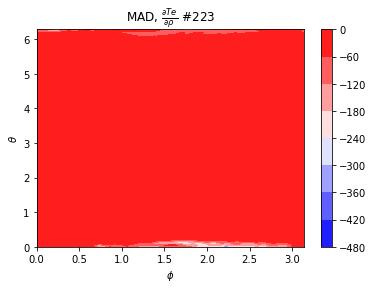

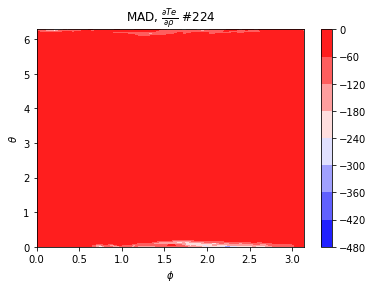

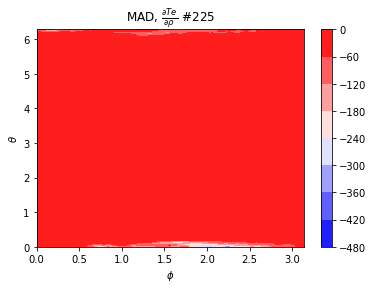

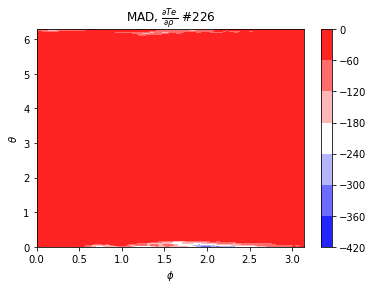

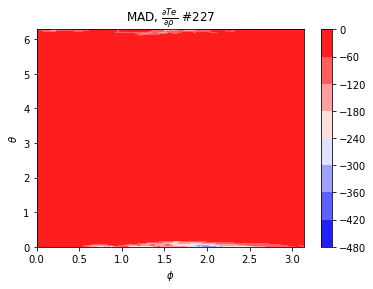

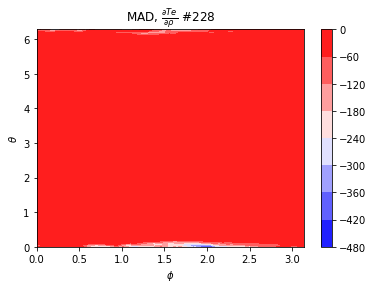

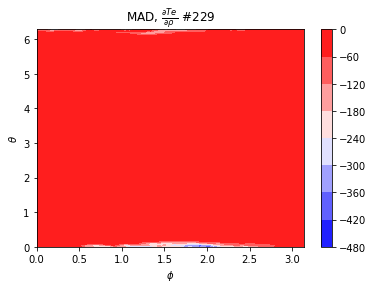

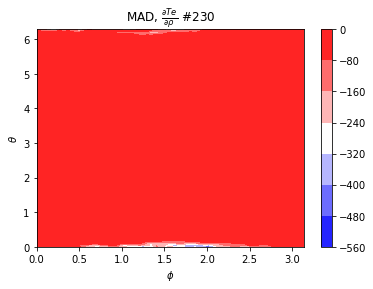

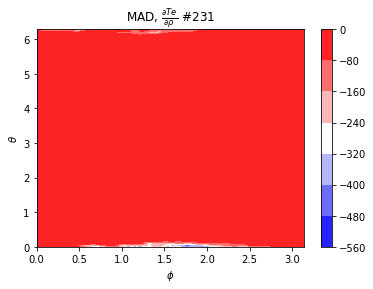

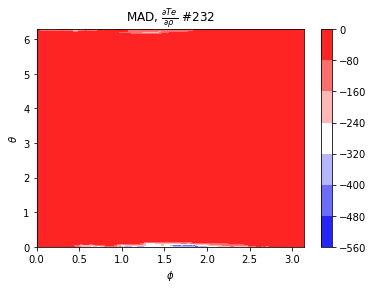

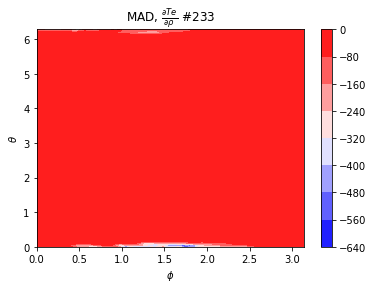

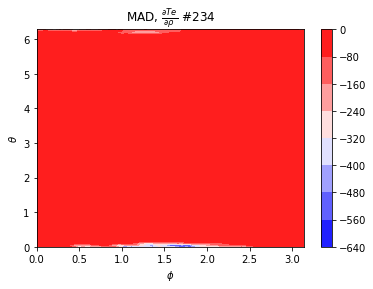

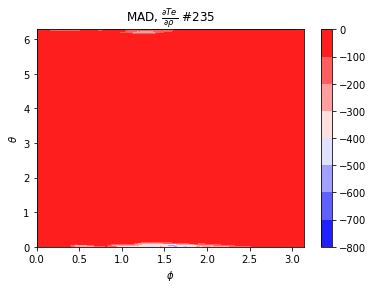

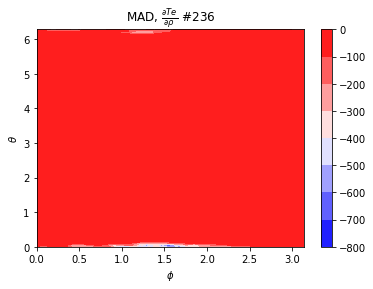

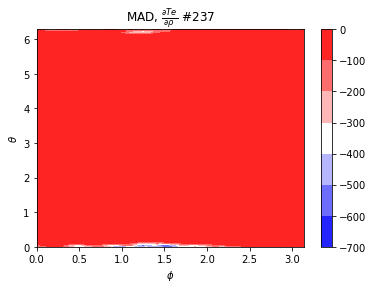

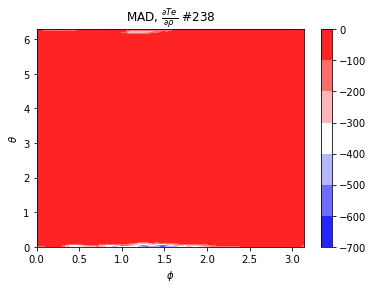

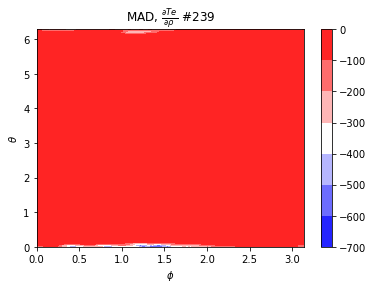

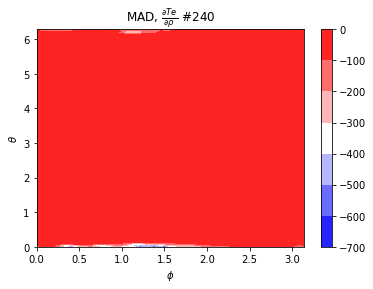

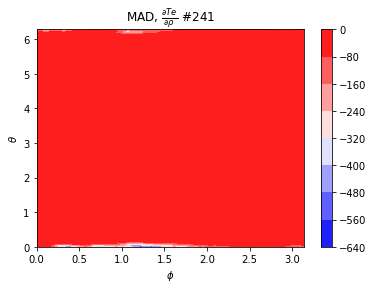

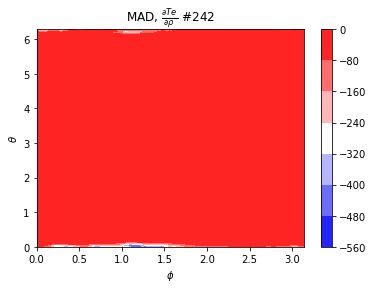

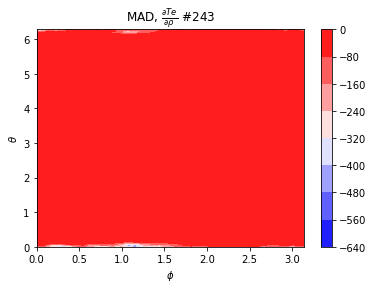

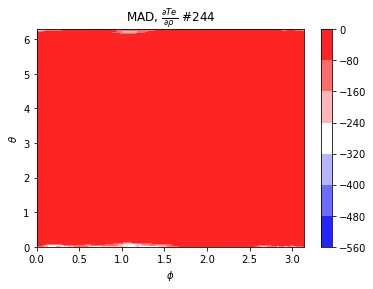

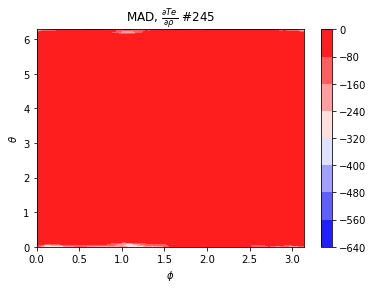

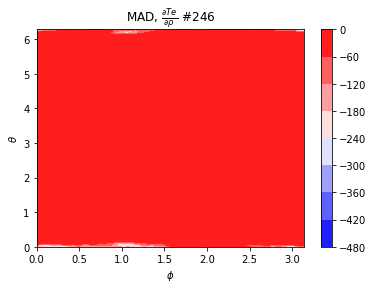

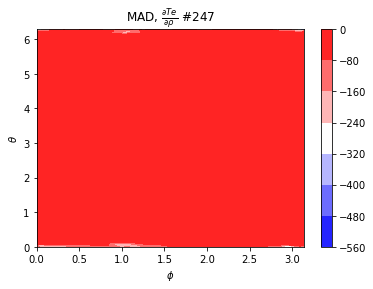

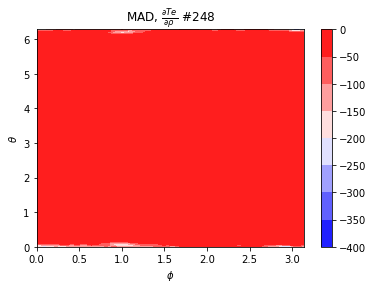

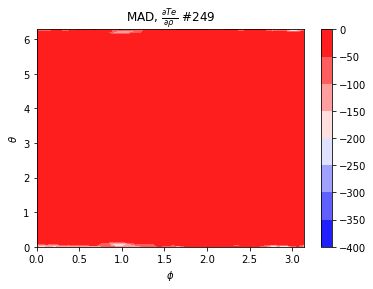

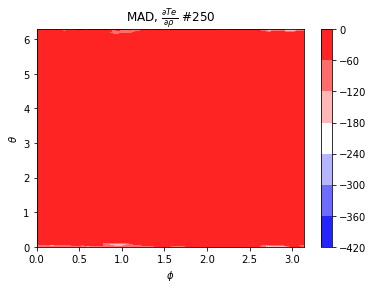

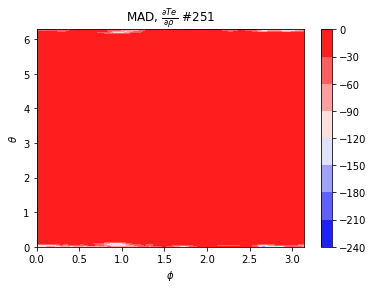

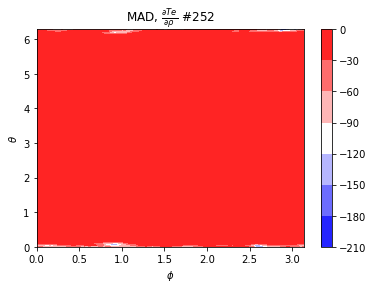

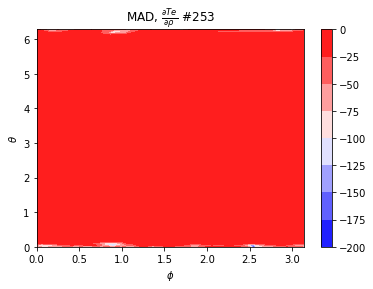

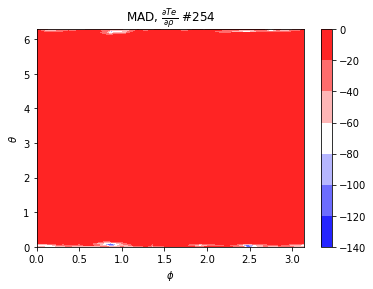

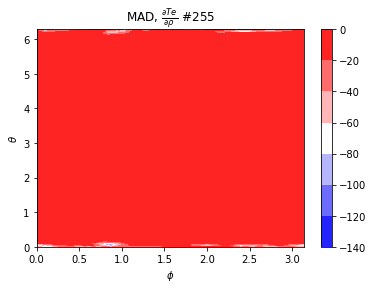

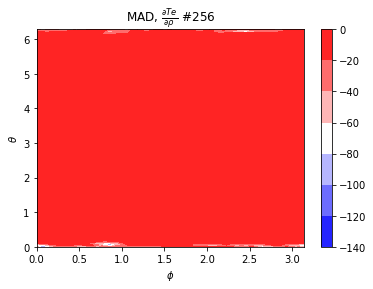

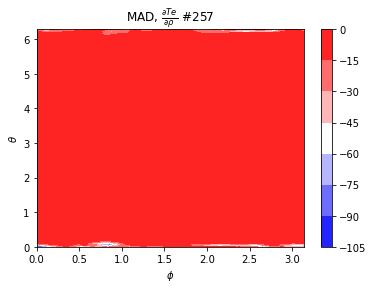

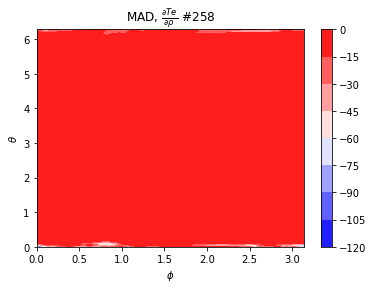

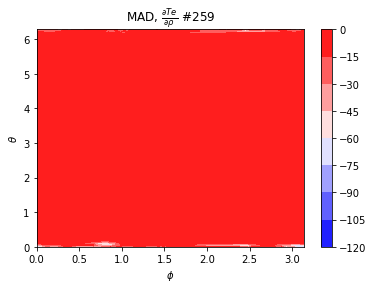

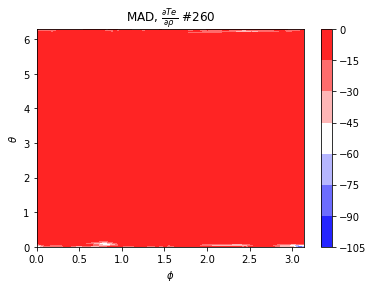

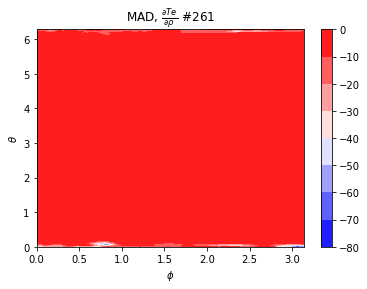

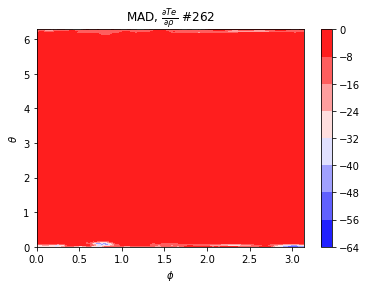

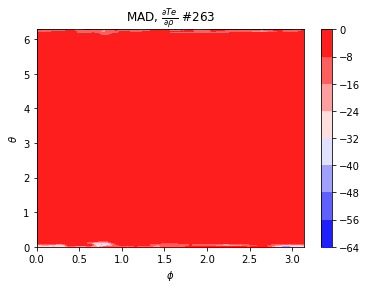

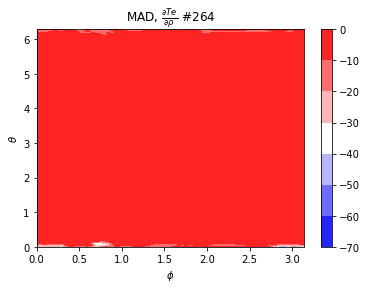

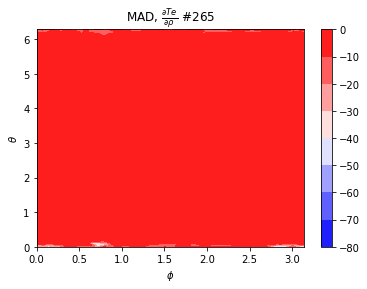

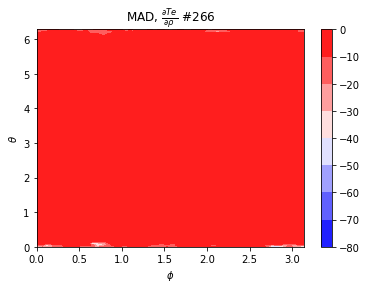

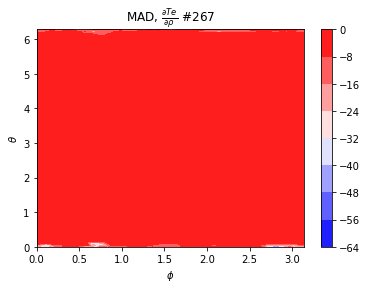

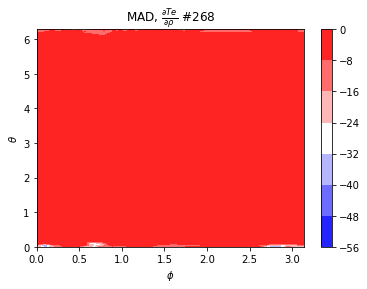

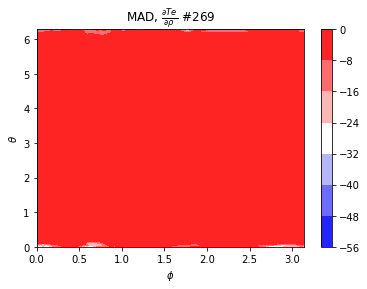

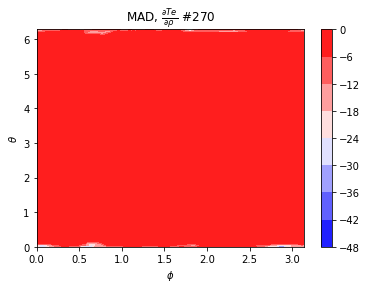

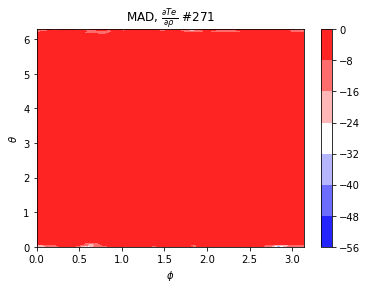

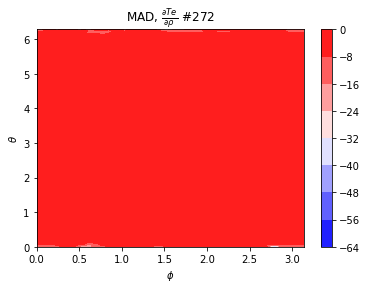

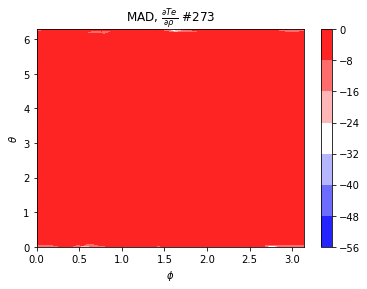

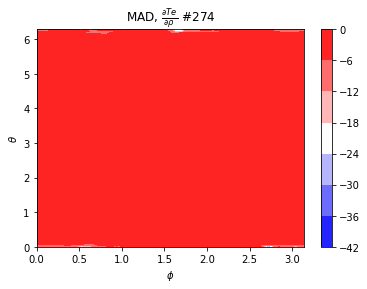

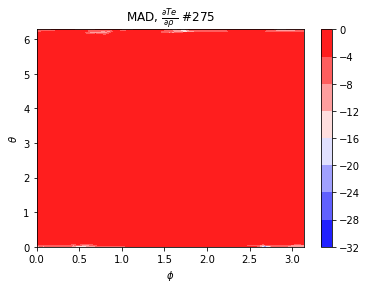

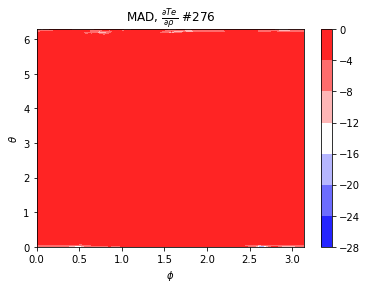

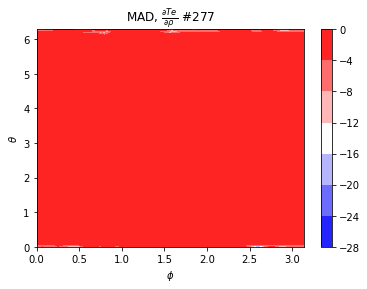

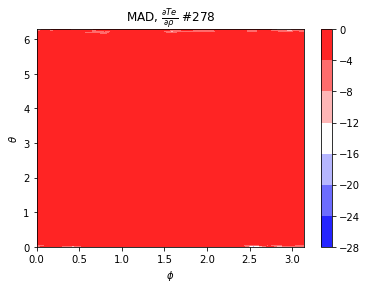

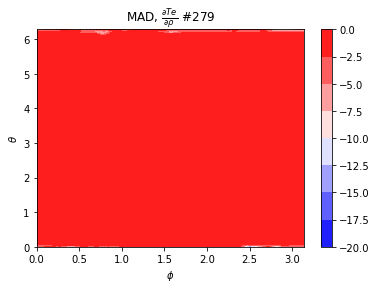

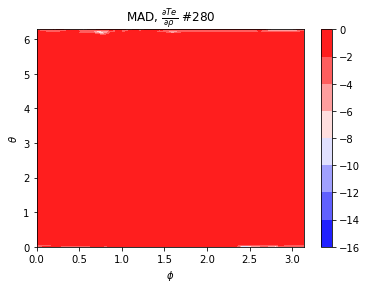

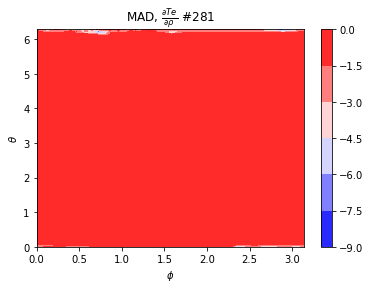

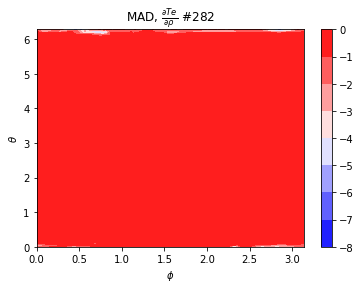

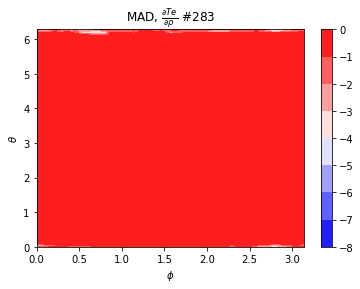

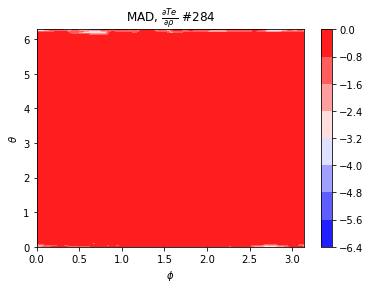

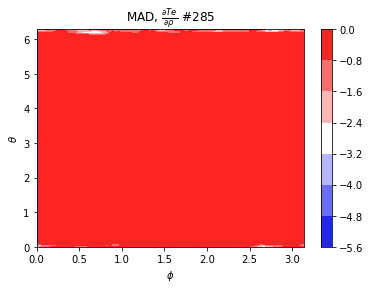

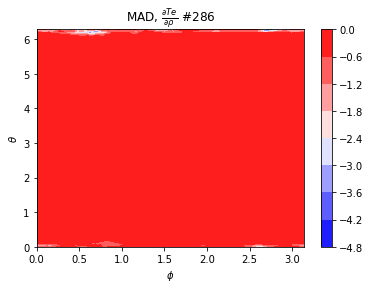

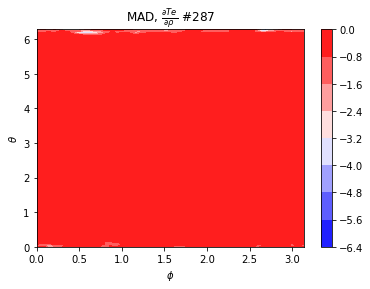

In [20]:
for i in range(0, 288, 1):
    twoD_contour(dumps_ma, 'avgD1', r'MAD, $\frac{\partial Te}{\partial \rho}$ #'+str(i), idx=i)
    plt.savefig('avg_D1_MAD_Rh160_rho'+str(i)+'.png')

$F_{2}$

In [17]:
for dump in dumps_ma.values():
    F2(dump, R_high[3], R_low)

In [18]:
Pg_ma_coeff_avg = average(range(i0, i1), dumps_ma, ['coeff2'])

finish average calculation.


In [19]:
for dump in dumps_ma.values():
    dump.cache['avgcoeff2'] = np.squeeze(np.array(list(Pg_ma_coeff_avg.values())))

In [20]:
save_var(dumps_ma, src_save_ma, Rh=160, quantity='avgcoeff2', loop=False)

In [18]:
Pg_ma_f1_avg = average(range(i0, i1), dumps_ma, ['D2'])

finish average calculation.


In [19]:
for dump in dumps_ma.values():
    dump.cache['avgD2'] = np.squeeze(np.array(list(Pg_ma_f1_avg.values())))

$F_{3}$

In [17]:
for dump in dumps_ma.values():
    F3(dump, R_high[3], R_low)

In [18]:
Pmag_ma_coeff_avg = average(range(i0, i1), dumps_ma, ['coeff3'])

finish average calculation.


In [19]:
for dump in dumps_ma.values():
    dump.cache['avgcoeff3'] = np.squeeze(np.array(list(Pmag_ma_coeff_avg.values())))

In [20]:
save_var(dumps_ma, src_save_ma, Rh=160, quantity='avgcoeff3', loop=False)

In [18]:
Pmag_ma_f1_avg = average(range(i0, i1), dumps_ma, ['D3'])

finish average calculation.


In [19]:
for dump in dumps_ma.values():
    dump.cache['avgD3'] = np.squeeze(np.array(list(Pmag_ma_f1_avg.values())))

### SANE

In [19]:
for dump in dumps_sa.values():
    dump['RHO']

$F_{1}$

In [17]:
for dump in dumps_sa.values():
    F1(dump, R_high[0], R_low)

In [ ]:
rho_sa_coeff_avg = average(range(i0, i1), dumps_sa, ['coeff1'])

In [ ]:
for dump in dumps_sa.values():
    dump.cache['avgcoeff1'] = np.squeeze(np.array(list(rho_sa_coeff_avg.values())))

In [ ]:
save_var(dumps_sa, src_save_sa, Rh=1, quantity='avgcoeff1', loop=False)

In [18]:
rho_sa_f1_avg = average(range(i0, i1), dumps_sa, ['D1'])

finish average calculation.


In [19]:
for dump in dumps_sa.values():
    dump.cache['avgD1'] = np.squeeze(np.array(list(rho_sa_f1_avg.values())))

$F_{2}$

In [17]:
for dump in dumps_sa.values():
    F2(dump, R_high[0], R_low)

In [18]:
Pg_sa_coeff_avg = average(range(i0, i1), dumps_sa, ['coeff2'])

finish average calculation.


In [19]:
for dump in dumps_sa.values():
    dump.cache['avgcoeff2'] = np.squeeze(np.array(list(Pg_sa_coeff_avg.values())))

In [ ]:
save_var(dumps_sa, src_save_sa, Rh=1, quantity='avgcoeff2', loop=False)

In [18]:
Pg_sa_f1_avg = average(range(i0, i1), dumps_sa, ['D2'])

finish average calculation.


In [19]:
for dump in dumps_sa.values():
    dump.cache['avgD2'] = np.squeeze(np.array(list(Pg_sa_f1_avg.values())))

$F_{3}$

In [16]:
for dump in dumps_sa.values():
    F3(dump, R_high[0], R_low)

In [17]:
print(dumps_sa[str(i0)].cache['coeff3'][0])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
twoD_contour(dumps_sa, 'coeff3', 'Filled Contours Plot [SANE, Coeff(Pmag)]')

### $R_{high}$=160, $R_{low}$=1

$F_{1}$

In [17]:
for dump in dumps_sa.values():
    F1(dump, R_high[3], R_low)

In [18]:
rho_sa_coeff_avg = average(range(i0, i1), dumps_sa, ['coeff1'])

finish average calculation.


In [19]:
for dump in dumps_sa.values():
    dump.cache['avgcoeff1'] = np.squeeze(np.array(list(rho_sa_coeff_avg.values())))

In [ ]:
save_var(dumps_sa, src_save_sa, Rh=160, quantity='avgcoeff1', loop=False)

In [18]:
rho_sa_f1_avg = average(range(i0, i1), dumps_sa, ['D1'])

finish average calculation.


In [19]:
for dump in dumps_sa.values():
    dump.cache['avgD1'] = np.squeeze(np.array(list(rho_sa_f1_avg.values())))

$F_{2}$

In [17]:
for dump in dumps_sa.values():
    F2(dump, R_high[3], R_low)

In [18]:
Pg_sa_coeff_avg = average(range(i0, i1), dumps_sa, ['coeff2'])

finish average calculation.


In [19]:
for dump in dumps_sa.values():
    dump.cache['avgcoeff2'] = np.squeeze(np.array(list(Pg_sa_coeff_avg.values())))

In [ ]:
save_var(dumps_sa, src_save_sa, Rh=160, quantity='avgcoeff2', loop=False)

In [18]:
Pg_sa_f1_avg = average(range(i0, i1), dumps_sa, ['D2'])

finish average calculation.


In [19]:
for dump in dumps_sa.values():
    dump.cache['avgD2'] = np.squeeze(np.array(list(Pg_sa_f1_avg.values())))

$F_{3}$

In [ ]:
for dump in dumps_sa.values():
    F3(dump, R_high[3], R_low)

In [18]:
Pmag_sa_coeff_avg = average(range(i0, i1), dumps_sa, ['coeff3'])

finish average calculation.


In [19]:
for dump in dumps_sa.values():
    dump.cache['avgcoeff3'] = np.squeeze(np.array(list(Pmag_sa_coeff_avg.values())))

In [ ]:
save_var(dumps_sa, src_save_sa, Rh=160, quantity='avgcoeff3', loop=False)

In [ ]:
Pmag_sa_f1_avg = average(range(i0, i1), dumps_sa, ['D3'])

In [ ]:
for dump in dumps_sa.values():
    dump.cache['avgD3'] = np.squeeze(np.array(list(Pmag_sa_f1_avg.values())))